# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-coreset'
epochs = 10
batch_size = 32
sequence_length = 64

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [10]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [11]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [12]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [13]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [14]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [15]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [16]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [17]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [18]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [19]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def coreset_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    embeddings = []
    
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
        embeddings.append(hidden_states.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Use pairwise distances to compute a distance matrix for Coreset selection
        distance_matrix = pairwise_distances(embeddings)    
        selected_indices = [0]  # Start with an arbitrary first sample (e.g., index 0)
        
        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices].min(axis=0)
        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        
        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend(selected_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [21]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [22]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5515, Accuracy: 0.8278, F1 Micro: 0.0526, F1 Macro: 0.0182
Epoch 2/10, Train Loss: 0.4092, Accuracy: 0.8295, F1 Micro: 0.0347, F1 Macro: 0.0148
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3802, Accuracy: 0.8324, F1 Micro: 0.0695, F1 Macro: 0.0281
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3552, Accuracy: 0.8526, F1 Micro: 0.3213, F1 Macro: 0.1074
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.342, Accuracy: 0.8673, F1 Micro: 0.4473, F1 Macro: 0.192
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3115, Accuracy: 0.8739, F1 Micro: 0.6072, F1 Macro: 0.2899
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.269, Accuracy: 0.8773, F1 Micro: 0.6207, F1 Macro: 0.3031
Epoch 8/10, Train Loss: 0.2578, Accuracy: 0.8806, F1 Micro: 0.5807, F1 Macro: 0.2899
Epoch 9/10, Train Loss: 0.2221, Accuracy: 0.8783, F1 Micro: 0.5331, F1 Macro: 0.2736
Epoch 10/10, Train Loss: 0.1966, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4989, Accuracy: 0.8146, F1 Micro: 0.5037, F1 Macro: 0.2163
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3993, Accuracy: 0.8737, F1 Micro: 0.598, F1 Macro: 0.2737
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3472, Accuracy: 0.8868, F1 Micro: 0.6438, F1 Macro: 0.3399
Epoch 4/10, Train Loss: 0.3065, Accuracy: 0.8915, F1 Micro: 0.6047, F1 Macro: 0.3423
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2556, Accuracy: 0.8999, F1 Micro: 0.6694, F1 Macro: 0.4498
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2181, Accuracy: 0.9007, F1 Micro: 0.6821, F1 Macro: 0.4673
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1878, Accuracy: 0.9014, F1 Micro: 0.6862, F1 Macro: 0.4905
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1614, Accuracy: 0.9045, F1 Micro: 0.6966, F1 Macro: 0.5593
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.135, Accuracy: 0.9027, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4725, Accuracy: 0.7892, F1 Micro: 0.5188, F1 Macro: 0.2321
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3709, Accuracy: 0.8889, F1 Micro: 0.6281, F1 Macro: 0.372
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3129, Accuracy: 0.9006, F1 Micro: 0.6712, F1 Macro: 0.4649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2581, Accuracy: 0.9059, F1 Micro: 0.7079, F1 Macro: 0.5242
Epoch 5/10, Train Loss: 0.2186, Accuracy: 0.9045, F1 Micro: 0.6975, F1 Macro: 0.5359
Epoch 6/10, Train Loss: 0.1763, Accuracy: 0.9063, F1 Micro: 0.7033, F1 Macro: 0.5788
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1481, Accuracy: 0.9069, F1 Micro: 0.7113, F1 Macro: 0.6121
Epoch 8/10, Train Loss: 0.1217, Accuracy: 0.9066, F1 Micro: 0.7098, F1 Macro: 0.6038
Epoch 9/10, Train Loss: 0.1028, Accuracy: 0.9074, F1 Micro: 0.7094, F1 Macro: 0.5981
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0841, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4609, Accuracy: 0.8203, F1 Micro: 0.5528, F1 Macro: 0.3175
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3549, Accuracy: 0.8931, F1 Micro: 0.6806, F1 Macro: 0.5124
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2897, Accuracy: 0.9069, F1 Micro: 0.7176, F1 Macro: 0.5722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2353, Accuracy: 0.897, F1 Micro: 0.7242, F1 Macro: 0.6019
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1959, Accuracy: 0.9122, F1 Micro: 0.737, F1 Macro: 0.6023
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1618, Accuracy: 0.9069, F1 Micro: 0.7392, F1 Macro: 0.636
Epoch 7/10, Train Loss: 0.1296, Accuracy: 0.9118, F1 Micro: 0.7331, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1022, Accuracy: 0.912, F1 Micro: 0.7424, F1 Macro: 0.6646
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.092, Accuracy: 0.9152, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4495, Accuracy: 0.8301, F1 Micro: 0.5715, F1 Macro: 0.3774
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3407, Accuracy: 0.8941, F1 Micro: 0.696, F1 Macro: 0.5191
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2763, Accuracy: 0.9101, F1 Micro: 0.7344, F1 Macro: 0.5927
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2213, Accuracy: 0.9174, F1 Micro: 0.7442, F1 Macro: 0.6127
Epoch 5/10, Train Loss: 0.1811, Accuracy: 0.9167, F1 Micro: 0.7289, F1 Macro: 0.6132
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1462, Accuracy: 0.9162, F1 Micro: 0.7499, F1 Macro: 0.6429
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.121, Accuracy: 0.9162, F1 Micro: 0.7514, F1 Macro: 0.6617
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0992, Accuracy: 0.9195, F1 Micro: 0.757, F1 Macro: 0.6842
Epoch 9/10, Train Loss: 0.0877, Accuracy: 0.9181, F1 Micro: 0.7501, F1 Macro: 0.6838
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4445, Accuracy: 0.8298, F1 Micro: 0.5826, F1 Macro: 0.3671
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3321, Accuracy: 0.9035, F1 Micro: 0.7103, F1 Macro: 0.5256
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2645, Accuracy: 0.9119, F1 Micro: 0.7409, F1 Macro: 0.6062
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2176, Accuracy: 0.9206, F1 Micro: 0.7593, F1 Macro: 0.643
Epoch 5/10, Train Loss: 0.1753, Accuracy: 0.9212, F1 Micro: 0.753, F1 Macro: 0.6568
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1397, Accuracy: 0.9201, F1 Micro: 0.7602, F1 Macro: 0.6598
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1146, Accuracy: 0.9204, F1 Micro: 0.7639, F1 Macro: 0.6794
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9173, F1 Micro: 0.7579, F1 Macro: 0.6887
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0782, Accuracy: 0.9213, F1 Micro: 0.7688, F1 Macro: 0.7071
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4392, Accuracy: 0.8627, F1 Micro: 0.6076, F1 Macro: 0.4265
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3352, Accuracy: 0.9061, F1 Micro: 0.7072, F1 Macro: 0.5364
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2648, Accuracy: 0.915, F1 Micro: 0.7557, F1 Macro: 0.6381
Epoch 4/10, Train Loss: 0.2142, Accuracy: 0.9183, F1 Micro: 0.7537, F1 Macro: 0.6264
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1734, Accuracy: 0.9189, F1 Micro: 0.766, F1 Macro: 0.6679
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1378, Accuracy: 0.9215, F1 Micro: 0.7731, F1 Macro: 0.6892
Epoch 7/10, Train Loss: 0.1153, Accuracy: 0.9202, F1 Micro: 0.7544, F1 Macro: 0.6799
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.921, F1 Micro: 0.7718, F1 Macro: 0.7011
Epoch 9/10, Train Loss: 0.0803, Accuracy: 0.9219, F1 Micro: 0.7638, F1 Macro: 0.7052
Epoch 10/10, Train Loss: 0.0663, Accuracy: 0.9227, F1 Micro: 0.7717, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4322, Accuracy: 0.8723, F1 Micro: 0.6364, F1 Macro: 0.4416
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3205, Accuracy: 0.9065, F1 Micro: 0.7355, F1 Macro: 0.5759
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2555, Accuracy: 0.9185, F1 Micro: 0.761, F1 Macro: 0.6143
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2065, Accuracy: 0.9249, F1 Micro: 0.7752, F1 Macro: 0.6696
Epoch 5/10, Train Loss: 0.1672, Accuracy: 0.9237, F1 Micro: 0.7666, F1 Macro: 0.6763
Epoch 6/10, Train Loss: 0.1334, Accuracy: 0.9255, F1 Micro: 0.7726, F1 Macro: 0.6903
Epoch 7/10, Train Loss: 0.1053, Accuracy: 0.9232, F1 Micro: 0.7707, F1 Macro: 0.7043
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.9233, F1 Micro: 0.7783, F1 Macro: 0.7081
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9215, F1 Micro: 0.7679, F1 Macro: 0.7063
Epoch 10/10, Train Loss: 0.0677, Accuracy: 0.9207, F1 Micro: 0.7705, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4145, Accuracy: 0.8812, F1 Micro: 0.6737, F1 Macro: 0.4928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3064, Accuracy: 0.9131, F1 Micro: 0.7387, F1 Macro: 0.5839
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2463, Accuracy: 0.9189, F1 Micro: 0.767, F1 Macro: 0.6213
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1971, Accuracy: 0.9233, F1 Micro: 0.7802, F1 Macro: 0.6762
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.9249, F1 Micro: 0.7745, F1 Macro: 0.6705
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.924, F1 Micro: 0.7802, F1 Macro: 0.7017
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.9226, F1 Micro: 0.7792, F1 Macro: 0.7051
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.9258, F1 Micro: 0.7786, F1 Macro: 0.7045
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0799, Accuracy: 0.9246, F1 Micro: 0.7827, F1 Macro: 0.7181
Epoch 10/10, Train Loss: 0.0643, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4098, Accuracy: 0.8949, F1 Micro: 0.6675, F1 Macro: 0.421
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2931, Accuracy: 0.9143, F1 Micro: 0.7401, F1 Macro: 0.5791
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2359, Accuracy: 0.921, F1 Micro: 0.7647, F1 Macro: 0.6381
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1874, Accuracy: 0.9264, F1 Micro: 0.7756, F1 Macro: 0.6739
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1505, Accuracy: 0.9264, F1 Micro: 0.7797, F1 Macro: 0.6954
Epoch 6/10, Train Loss: 0.122, Accuracy: 0.9245, F1 Micro: 0.7786, F1 Macro: 0.7005
Epoch 7/10, Train Loss: 0.1006, Accuracy: 0.9242, F1 Micro: 0.7753, F1 Macro: 0.7041
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9235, F1 Micro: 0.7771, F1 Macro: 0.7124
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9234, F1 Micro: 0.7674, F1 Macro: 0.7018
Epoch 10/10, Train Loss: 0.0591, Accuracy: 0.9255, F1 Micro: 0.7761, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4008, Accuracy: 0.8952, F1 Micro: 0.6996, F1 Macro: 0.4966
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2796, Accuracy: 0.9136, F1 Micro: 0.7453, F1 Macro: 0.5624
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.223, Accuracy: 0.921, F1 Micro: 0.7688, F1 Macro: 0.6427
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9227, F1 Micro: 0.7694, F1 Macro: 0.6377
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9269, F1 Micro: 0.7812, F1 Macro: 0.6761
Epoch 6/10, Train Loss: 0.115, Accuracy: 0.9234, F1 Micro: 0.7745, F1 Macro: 0.694
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0932, Accuracy: 0.9264, F1 Micro: 0.7822, F1 Macro: 0.7106
Epoch 8/10, Train Loss: 0.0794, Accuracy: 0.9199, F1 Micro: 0.7694, F1 Macro: 0.7072
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9251, F1 Micro: 0.7736, F1 Macro: 0.7098
Epoch 10/10, Train Loss: 0.0572, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3868, Accuracy: 0.9011, F1 Micro: 0.6993, F1 Macro: 0.4893
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2698, Accuracy: 0.9159, F1 Micro: 0.742, F1 Macro: 0.5824
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2131, Accuracy: 0.9242, F1 Micro: 0.7749, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.9263, F1 Micro: 0.7778, F1 Macro: 0.6734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1364, Accuracy: 0.9278, F1 Micro: 0.7782, F1 Macro: 0.6738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1137, Accuracy: 0.9251, F1 Micro: 0.7803, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.928, F1 Micro: 0.7834, F1 Macro: 0.7192
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9262, F1 Micro: 0.7856, F1 Macro: 0.7264
Epoch 9/10, Train Loss: 0.0646, Accuracy: 0.9231, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3778, Accuracy: 0.9003, F1 Micro: 0.6851, F1 Macro: 0.439
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.911, F1 Micro: 0.7529, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.208, Accuracy: 0.9213, F1 Micro: 0.7716, F1 Macro: 0.6192
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9254, F1 Micro: 0.7813, F1 Macro: 0.6803
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.9269, F1 Micro: 0.7833, F1 Macro: 0.697
Epoch 6/10, Train Loss: 0.1107, Accuracy: 0.9239, F1 Micro: 0.7758, F1 Macro: 0.6981
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.9256, F1 Micro: 0.7751, F1 Macro: 0.7032
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9266, F1 Micro: 0.7863, F1 Macro: 0.7247
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9267, F1 Micro: 0.7836, F1 Macro: 0.7176
Epoch 10/10, Train Loss: 0.0528, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3805, Accuracy: 0.8977, F1 Micro: 0.7067, F1 Macro: 0.5066
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.256, Accuracy: 0.9178, F1 Micro: 0.7548, F1 Macro: 0.5915
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2018, Accuracy: 0.9225, F1 Micro: 0.7557, F1 Macro: 0.6327
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9271, F1 Micro: 0.778, F1 Macro: 0.6696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.9257, F1 Micro: 0.7789, F1 Macro: 0.6628
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1098, Accuracy: 0.9261, F1 Micro: 0.7844, F1 Macro: 0.7024
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.9261, F1 Micro: 0.7809, F1 Macro: 0.708
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9256, F1 Micro: 0.7799, F1 Macro: 0.7175
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.924, F1 Micro: 0.777, F1 Macro: 0.7083
Epoch 10/10, Train Loss: 0.0501, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3658, Accuracy: 0.9009, F1 Micro: 0.6815, F1 Macro: 0.466
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2506, Accuracy: 0.9169, F1 Micro: 0.7632, F1 Macro: 0.6191
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1963, Accuracy: 0.9262, F1 Micro: 0.777, F1 Macro: 0.6507
Epoch 4/10, Train Loss: 0.1544, Accuracy: 0.9225, F1 Micro: 0.7746, F1 Macro: 0.659
Epoch 5/10, Train Loss: 0.1311, Accuracy: 0.9266, F1 Micro: 0.771, F1 Macro: 0.6851
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.9269, F1 Micro: 0.7865, F1 Macro: 0.7075
Epoch 7/10, Train Loss: 0.0832, Accuracy: 0.9234, F1 Micro: 0.7781, F1 Macro: 0.7064
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.9267, F1 Micro: 0.7857, F1 Macro: 0.7215
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.9259, F1 Micro: 0.7739, F1 Macro: 0.718
Epoch 10/10, Train Loss: 0.0493, Accuracy: 0.9258, F1 Micro: 0.7858, F1 Macro: 0.7196

 Iteration 8165: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3606, Accuracy: 0.8996, F1 Micro: 0.7095, F1 Macro: 0.4916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2411, Accuracy: 0.9168, F1 Micro: 0.7439, F1 Macro: 0.5751
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1915, Accuracy: 0.9268, F1 Micro: 0.7802, F1 Macro: 0.6698
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.9239, F1 Micro: 0.7779, F1 Macro: 0.6798
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9252, F1 Micro: 0.7856, F1 Macro: 0.7054
Epoch 6/10, Train Loss: 0.1006, Accuracy: 0.9238, F1 Micro: 0.7812, F1 Macro: 0.7048
Epoch 7/10, Train Loss: 0.0793, Accuracy: 0.9241, F1 Micro: 0.7753, F1 Macro: 0.7175
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0673, Accuracy: 0.9271, F1 Micro: 0.7869, F1 Macro: 0.7113
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9216, F1 Micro: 0.7784, F1 Macro: 0.719
Epoch 10/10, Train Loss: 0.0467, Accuracy: 0.9242, F1 Micro: 0.7825, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3573, Accuracy: 0.9034, F1 Micro: 0.6984, F1 Macro: 0.5134
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2402, Accuracy: 0.916, F1 Micro: 0.7556, F1 Macro: 0.6017
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1866, Accuracy: 0.9245, F1 Micro: 0.7802, F1 Macro: 0.6344
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.928, F1 Micro: 0.7776, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9283, F1 Micro: 0.7907, F1 Macro: 0.691
Epoch 6/10, Train Loss: 0.0974, Accuracy: 0.9242, F1 Micro: 0.778, F1 Macro: 0.694
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9262, F1 Micro: 0.7708, F1 Macro: 0.6895
Epoch 8/10, Train Loss: 0.0668, Accuracy: 0.9257, F1 Micro: 0.7812, F1 Macro: 0.7155
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9267, F1 Micro: 0.7783, F1 Macro: 0.7173
Epoch 10/10, Train Loss: 0.0448, Accuracy: 0.9235, F1 Micro: 0.7759, F1 Macro: 0.7149

 Iteration 8616: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3576, Accuracy: 0.9044, F1 Micro: 0.6865, F1 Macro: 0.4657
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2377, Accuracy: 0.9188, F1 Micro: 0.7491, F1 Macro: 0.5906
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1882, Accuracy: 0.9212, F1 Micro: 0.7766, F1 Macro: 0.6379
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.9285, F1 Micro: 0.7788, F1 Macro: 0.6487
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9277, F1 Micro: 0.786, F1 Macro: 0.6912
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.9225, F1 Micro: 0.7823, F1 Macro: 0.7007
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.9282, F1 Micro: 0.7818, F1 Macro: 0.7071
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9269, F1 Micro: 0.7882, F1 Macro: 0.7199
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9273, F1 Micro: 0.7846, F1 Macro: 0.7191
Epoch 10/10, Train Loss: 0.048, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.35, Accuracy: 0.9041, F1 Micro: 0.7187, F1 Macro: 0.5185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2307, Accuracy: 0.9165, F1 Micro: 0.7511, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1859, Accuracy: 0.9234, F1 Micro: 0.7769, F1 Macro: 0.6386
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.9274, F1 Micro: 0.779, F1 Macro: 0.6745
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1187, Accuracy: 0.9262, F1 Micro: 0.7814, F1 Macro: 0.6918
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0964, Accuracy: 0.929, F1 Micro: 0.7933, F1 Macro: 0.7198
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.9294, F1 Micro: 0.7876, F1 Macro: 0.713
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9263, F1 Micro: 0.7845, F1 Macro: 0.7159
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.9261, F1 Micro: 0.7832, F1 Macro: 0.7175
Epoch 10/10, Train Loss: 0.0468, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3505, Accuracy: 0.902, F1 Micro: 0.6934, F1 Macro: 0.4098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2369, Accuracy: 0.9191, F1 Micro: 0.7371, F1 Macro: 0.5735
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1783, Accuracy: 0.9242, F1 Micro: 0.7632, F1 Macro: 0.6384
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1428, Accuracy: 0.9247, F1 Micro: 0.786, F1 Macro: 0.6673
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.9243, F1 Micro: 0.784, F1 Macro: 0.6907
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9261, F1 Micro: 0.7784, F1 Macro: 0.6982
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9271, F1 Micro: 0.7896, F1 Macro: 0.7233
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.923, F1 Micro: 0.7834, F1 Macro: 0.7193
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9279, F1 Micro: 0.7846, F1 Macro: 0.7201
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0447, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3443, Accuracy: 0.9033, F1 Micro: 0.671, F1 Macro: 0.4452
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2288, Accuracy: 0.9191, F1 Micro: 0.7539, F1 Macro: 0.5861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1806, Accuracy: 0.9249, F1 Micro: 0.7779, F1 Macro: 0.6367
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1439, Accuracy: 0.9267, F1 Micro: 0.7829, F1 Macro: 0.6813
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1171, Accuracy: 0.9278, F1 Micro: 0.7931, F1 Macro: 0.7209
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9255, F1 Micro: 0.7831, F1 Macro: 0.6987
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9284, F1 Micro: 0.7823, F1 Macro: 0.7155
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.9284, F1 Micro: 0.7897, F1 Macro: 0.7255
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9285, F1 Micro: 0.7892, F1 Macro: 0.7254
Epoch 10/10, Train Loss: 0.044, Accuracy: 0.927, F1 Micro: 0.783, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.346, Accuracy: 0.9055, F1 Micro: 0.7152, F1 Macro: 0.4987
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2252, Accuracy: 0.9188, F1 Micro: 0.7583, F1 Macro: 0.5906
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1818, Accuracy: 0.9243, F1 Micro: 0.7706, F1 Macro: 0.6312
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1463, Accuracy: 0.9279, F1 Micro: 0.7765, F1 Macro: 0.6398
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9278, F1 Micro: 0.7869, F1 Macro: 0.6741
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.9292, F1 Micro: 0.7844, F1 Macro: 0.7088
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.9274, F1 Micro: 0.7827, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9299, F1 Micro: 0.7924, F1 Macro: 0.7294
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9255, F1 Micro: 0.7741, F1 Macro: 0.7132
Epoch 10/10, Train Loss: 0.044, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3406, Accuracy: 0.9065, F1 Micro: 0.7108, F1 Macro: 0.5086
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2241, Accuracy: 0.9208, F1 Micro: 0.7696, F1 Macro: 0.6175
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1779, Accuracy: 0.922, F1 Micro: 0.7761, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9292, F1 Micro: 0.7805, F1 Macro: 0.6487
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9289, F1 Micro: 0.7895, F1 Macro: 0.6875
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9271, F1 Micro: 0.7868, F1 Macro: 0.7177
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9271, F1 Micro: 0.7888, F1 Macro: 0.7198
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9231, F1 Micro: 0.7792, F1 Macro: 0.7081
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9248, F1 Micro: 0.7872, F1 Macro: 0.7235
Epoch 10/10, Train Loss: 0.0446, Accuracy: 0.9265, F1 Micro: 0.7869, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3394, Accuracy: 0.9051, F1 Micro: 0.7168, F1 Macro: 0.5322
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2272, Accuracy: 0.9186, F1 Micro: 0.7601, F1 Macro: 0.6043
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1785, Accuracy: 0.9236, F1 Micro: 0.7736, F1 Macro: 0.6326
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.141, Accuracy: 0.9252, F1 Micro: 0.777, F1 Macro: 0.6742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1113, Accuracy: 0.9283, F1 Micro: 0.7779, F1 Macro: 0.6786
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9263, F1 Micro: 0.7859, F1 Macro: 0.701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9285, F1 Micro: 0.7916, F1 Macro: 0.7264
Epoch 8/10, Train Loss: 0.0581, Accuracy: 0.929, F1 Micro: 0.7914, F1 Macro: 0.7218
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9262, F1 Micro: 0.7835, F1 Macro: 0.721
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3359, Accuracy: 0.9051, F1 Micro: 0.7139, F1 Macro: 0.4851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2237, Accuracy: 0.9187, F1 Micro: 0.7594, F1 Macro: 0.6037
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1776, Accuracy: 0.924, F1 Micro: 0.7758, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1369, Accuracy: 0.9275, F1 Micro: 0.7815, F1 Macro: 0.6793
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1123, Accuracy: 0.9293, F1 Micro: 0.7939, F1 Macro: 0.7131
Epoch 6/10, Train Loss: 0.0904, Accuracy: 0.9289, F1 Micro: 0.7867, F1 Macro: 0.7096
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9292, F1 Micro: 0.7891, F1 Macro: 0.7122
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.929, F1 Micro: 0.791, F1 Macro: 0.7236
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9293, F1 Micro: 0.7905, F1 Macro: 0.7227
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0414, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3273, Accuracy: 0.9071, F1 Micro: 0.714, F1 Macro: 0.5148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2204, Accuracy: 0.9197, F1 Micro: 0.7509, F1 Macro: 0.6058
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1754, Accuracy: 0.9245, F1 Micro: 0.7772, F1 Macro: 0.6549
Epoch 4/10, Train Loss: 0.1396, Accuracy: 0.9264, F1 Micro: 0.7682, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1073, Accuracy: 0.9273, F1 Micro: 0.7923, F1 Macro: 0.7098
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9213, F1 Micro: 0.7787, F1 Macro: 0.7072
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9267, F1 Micro: 0.7876, F1 Macro: 0.7128
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9267, F1 Micro: 0.7892, F1 Macro: 0.7243
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9285, F1 Micro: 0.7915, F1 Macro: 0.7302
Epoch 10/10, Train Loss: 0.0444, Accuracy: 0.9285, F1 Micro: 0.7896, F1 Macro: 0.7263

 Iteration 10218:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.331, Accuracy: 0.9066, F1 Micro: 0.7109, F1 Macro: 0.5352
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2206, Accuracy: 0.9209, F1 Micro: 0.7429, F1 Macro: 0.5858
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1737, Accuracy: 0.9274, F1 Micro: 0.7752, F1 Macro: 0.6458
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.134, Accuracy: 0.9272, F1 Micro: 0.7839, F1 Macro: 0.6566
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.11, Accuracy: 0.9272, F1 Micro: 0.7913, F1 Macro: 0.7003
Epoch 6/10, Train Loss: 0.0862, Accuracy: 0.9285, F1 Micro: 0.7856, F1 Macro: 0.7059
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9281, F1 Micro: 0.7888, F1 Macro: 0.7145
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9277, F1 Micro: 0.7834, F1 Macro: 0.7215
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9294, F1 Micro: 0.7921, F1 Macro: 0.7346
Epoch 10/10, Train Loss: 0.0409, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3259, Accuracy: 0.9079, F1 Micro: 0.7003, F1 Macro: 0.5112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2173, Accuracy: 0.9209, F1 Micro: 0.7516, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1681, Accuracy: 0.9247, F1 Micro: 0.775, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1369, Accuracy: 0.9257, F1 Micro: 0.7806, F1 Macro: 0.6717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9262, F1 Micro: 0.7857, F1 Macro: 0.7005
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.9257, F1 Micro: 0.7819, F1 Macro: 0.683
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9256, F1 Micro: 0.7863, F1 Macro: 0.7224
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9254, F1 Micro: 0.7848, F1 Macro: 0.7298
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.926, F1 Micro: 0.7864, F1 Macro: 0.7118
Epoch 10

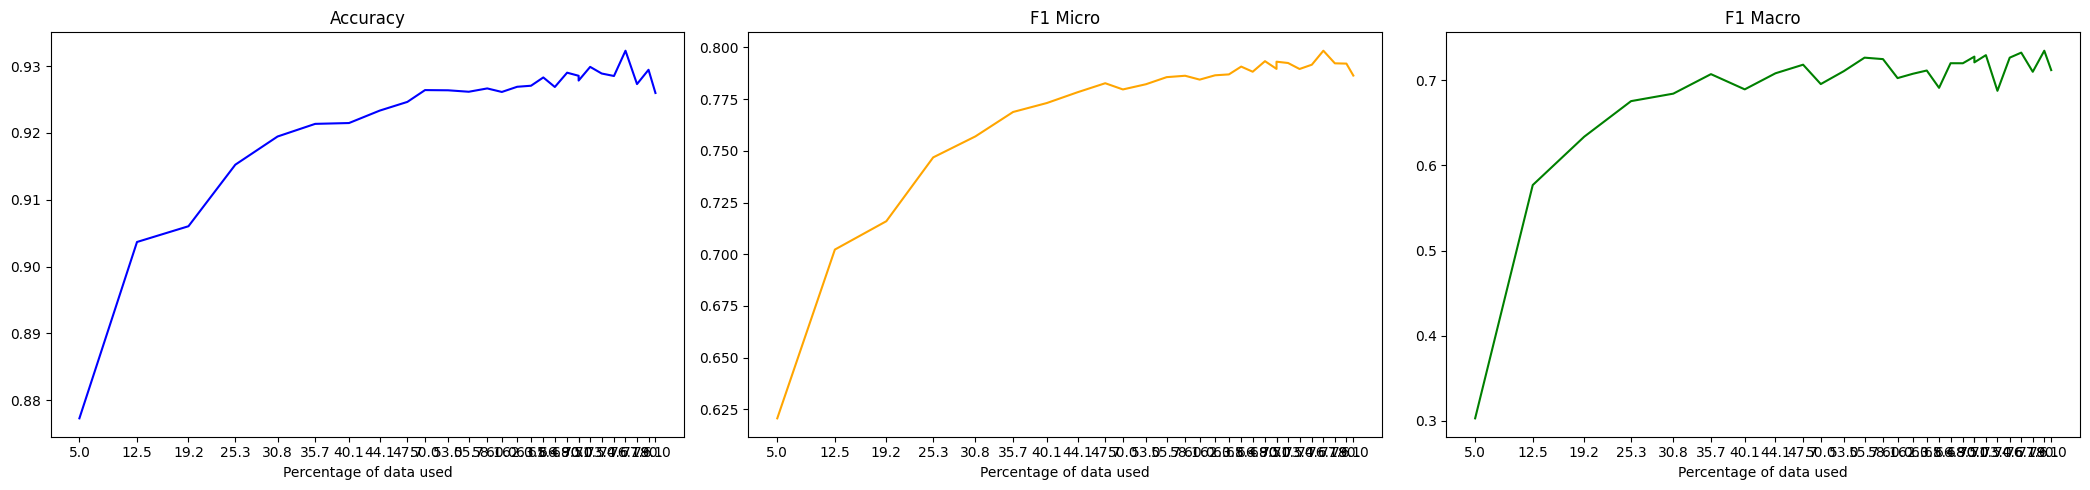

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5266, Accuracy: 0.8301, F1 Micro: 0.2891, F1 Macro: 0.0662
Epoch 2/10, Train Loss: 0.3942, Accuracy: 0.8359, F1 Micro: 0.1442, F1 Macro: 0.0503
Epoch 3/10, Train Loss: 0.3671, Accuracy: 0.8486, F1 Micro: 0.2855, F1 Macro: 0.1017
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3413, Accuracy: 0.867, F1 Micro: 0.4893, F1 Macro: 0.2134
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3096, Accuracy: 0.8779, F1 Micro: 0.5722, F1 Macro: 0.2657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2733, Accuracy: 0.8816, F1 Micro: 0.5875, F1 Macro: 0.2778
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2475, Accuracy: 0.8853, F1 Micro: 0.601, F1 Macro: 0.2967
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2294, Accuracy: 0.888, F1 Micro: 0.6436, F1 Macro: 0.3443
Epoch 9/10, Train Loss: 0.198, Accuracy: 0.8897, F1 Micro: 0.6336, F1 Macro: 0.3385
Epoch 10/10, Train Loss: 0.1811, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4942, Accuracy: 0.8162, F1 Micro: 0.5136, F1 Macro: 0.2231
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3862, Accuracy: 0.8638, F1 Micro: 0.5934, F1 Macro: 0.2968
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3279, Accuracy: 0.8848, F1 Micro: 0.6275, F1 Macro: 0.3623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2887, Accuracy: 0.8964, F1 Micro: 0.6501, F1 Macro: 0.4151
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2444, Accuracy: 0.9004, F1 Micro: 0.6513, F1 Macro: 0.4586
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2103, Accuracy: 0.9032, F1 Micro: 0.6771, F1 Macro: 0.5213
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.178, Accuracy: 0.9027, F1 Micro: 0.6879, F1 Macro: 0.524
Epoch 8/10, Train Loss: 0.1526, Accuracy: 0.9017, F1 Micro: 0.6796, F1 Macro: 0.5499
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1285, Accuracy: 0.9045, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.465, Accuracy: 0.8137, F1 Micro: 0.5442, F1 Macro: 0.2747
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3592, Accuracy: 0.8836, F1 Micro: 0.6543, F1 Macro: 0.4121
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2947, Accuracy: 0.9017, F1 Micro: 0.6866, F1 Macro: 0.4938
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2478, Accuracy: 0.9087, F1 Micro: 0.7085, F1 Macro: 0.55
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2068, Accuracy: 0.9082, F1 Micro: 0.7282, F1 Macro: 0.5909
Epoch 6/10, Train Loss: 0.1702, Accuracy: 0.9111, F1 Micro: 0.7239, F1 Macro: 0.6013
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1418, Accuracy: 0.9104, F1 Micro: 0.7296, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1158, Accuracy: 0.9113, F1 Micro: 0.7351, F1 Macro: 0.6339
Epoch 9/10, Train Loss: 0.1, Accuracy: 0.914, F1 Micro: 0.7314, F1 Macro: 0.626
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4554, Accuracy: 0.8173, F1 Micro: 0.5502, F1 Macro: 0.3214
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3486, Accuracy: 0.8943, F1 Micro: 0.6826, F1 Macro: 0.5046
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2815, Accuracy: 0.9038, F1 Micro: 0.7221, F1 Macro: 0.574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.239, Accuracy: 0.9133, F1 Micro: 0.7301, F1 Macro: 0.5871
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1915, Accuracy: 0.9116, F1 Micro: 0.7413, F1 Macro: 0.6164
Epoch 6/10, Train Loss: 0.1589, Accuracy: 0.9147, F1 Micro: 0.7341, F1 Macro: 0.6302
Epoch 7/10, Train Loss: 0.1237, Accuracy: 0.9148, F1 Micro: 0.7323, F1 Macro: 0.6385
Epoch 8/10, Train Loss: 0.11, Accuracy: 0.9136, F1 Micro: 0.7342, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.093, Accuracy: 0.9162, F1 Micro: 0.7414, F1 Macro: 0.6653
Epoch 10/10, Train Loss: 0.0802, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4453, Accuracy: 0.8322, F1 Micro: 0.5733, F1 Macro: 0.3575
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3366, Accuracy: 0.8909, F1 Micro: 0.7036, F1 Macro: 0.546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2733, Accuracy: 0.9079, F1 Micro: 0.7427, F1 Macro: 0.5947
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2247, Accuracy: 0.9171, F1 Micro: 0.7569, F1 Macro: 0.6148
Epoch 5/10, Train Loss: 0.1844, Accuracy: 0.9189, F1 Micro: 0.7563, F1 Macro: 0.6381
Epoch 6/10, Train Loss: 0.1479, Accuracy: 0.9206, F1 Micro: 0.7506, F1 Macro: 0.6648
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1201, Accuracy: 0.9198, F1 Micro: 0.7582, F1 Macro: 0.669
Epoch 8/10, Train Loss: 0.1006, Accuracy: 0.9192, F1 Micro: 0.7482, F1 Macro: 0.6662
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0888, Accuracy: 0.9187, F1 Micro: 0.7625, F1 Macro: 0.6949
Epoch 10/10, Train Loss: 0.0745, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.434, Accuracy: 0.8566, F1 Micro: 0.6297, F1 Macro: 0.4192
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3197, Accuracy: 0.9077, F1 Micro: 0.7148, F1 Macro: 0.52
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2604, Accuracy: 0.9162, F1 Micro: 0.7468, F1 Macro: 0.5922
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2079, Accuracy: 0.9193, F1 Micro: 0.7623, F1 Macro: 0.6181
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.169, Accuracy: 0.917, F1 Micro: 0.7648, F1 Macro: 0.6776
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1378, Accuracy: 0.9203, F1 Micro: 0.7682, F1 Macro: 0.6462
Epoch 7/10, Train Loss: 0.1204, Accuracy: 0.9216, F1 Micro: 0.7574, F1 Macro: 0.6674
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.9217, F1 Micro: 0.753, F1 Macro: 0.6698
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0837, Accuracy: 0.9228, F1 Micro: 0.7756, F1 Macro: 0.7007
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4109, Accuracy: 0.8943, F1 Micro: 0.6537, F1 Macro: 0.4255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2875, Accuracy: 0.9112, F1 Micro: 0.7297, F1 Macro: 0.554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2343, Accuracy: 0.9171, F1 Micro: 0.7537, F1 Macro: 0.6036
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1862, Accuracy: 0.9182, F1 Micro: 0.765, F1 Macro: 0.6259
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.9191, F1 Micro: 0.744, F1 Macro: 0.6461
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9224, F1 Micro: 0.7647, F1 Macro: 0.6654
Epoch 7/10, Train Loss: 0.1021, Accuracy: 0.923, F1 Micro: 0.7624, F1 Macro: 0.6753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9253, F1 Micro: 0.7733, F1 Macro: 0.7
Epoch 9/10, Train Loss: 0.0729, Accuracy: 0.9209, F1 Micro: 0.7725, F1 Macro: 0.707
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0625, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3982, Accuracy: 0.8975, F1 Micro: 0.6827, F1 Macro: 0.4344
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2793, Accuracy: 0.9125, F1 Micro: 0.7415, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2281, Accuracy: 0.9182, F1 Micro: 0.7526, F1 Macro: 0.612
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.9235, F1 Micro: 0.7677, F1 Macro: 0.6318
Epoch 5/10, Train Loss: 0.1469, Accuracy: 0.9227, F1 Micro: 0.7635, F1 Macro: 0.6457
Epoch 6/10, Train Loss: 0.1211, Accuracy: 0.9232, F1 Micro: 0.7596, F1 Macro: 0.6487
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.9254, F1 Micro: 0.7816, F1 Macro: 0.6902
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.9239, F1 Micro: 0.7762, F1 Macro: 0.6984
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9245, F1 Micro: 0.7715, F1 Macro: 0.6913
Epoch 10/10, Train Loss: 0.0628, Accuracy: 0.9203, F1 Micro: 0.7749, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3973, Accuracy: 0.8962, F1 Micro: 0.6769, F1 Macro: 0.4196
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2765, Accuracy: 0.9128, F1 Micro: 0.7404, F1 Macro: 0.559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2197, Accuracy: 0.9185, F1 Micro: 0.7533, F1 Macro: 0.606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9243, F1 Micro: 0.7763, F1 Macro: 0.6588
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1388, Accuracy: 0.9246, F1 Micro: 0.7787, F1 Macro: 0.6692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.115, Accuracy: 0.9233, F1 Micro: 0.7819, F1 Macro: 0.6994
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9231, F1 Micro: 0.7802, F1 Macro: 0.6915
Epoch 8/10, Train Loss: 0.0782, Accuracy: 0.9258, F1 Micro: 0.7818, F1 Macro: 0.7081
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9266, F1 Micro: 0.7776, F1 Macro: 0.713
Epoch 10/10, Train Loss: 0.0543, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3885, Accuracy: 0.8945, F1 Micro: 0.6944, F1 Macro: 0.5048
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2656, Accuracy: 0.9143, F1 Micro: 0.7451, F1 Macro: 0.583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2163, Accuracy: 0.9223, F1 Micro: 0.7611, F1 Macro: 0.6102
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.9221, F1 Micro: 0.7537, F1 Macro: 0.6368
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9239, F1 Micro: 0.7792, F1 Macro: 0.6607
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.9257, F1 Micro: 0.7777, F1 Macro: 0.6964
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0906, Accuracy: 0.9249, F1 Micro: 0.7793, F1 Macro: 0.7037
Epoch 8/10, Train Loss: 0.0794, Accuracy: 0.9244, F1 Micro: 0.7696, F1 Macro: 0.6867
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0646, Accuracy: 0.9249, F1 Micro: 0.7818, F1 Macro: 0.7158
Epoch 10/10, Train Loss: 0.0575, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3724, Accuracy: 0.8997, F1 Micro: 0.7085, F1 Macro: 0.4821
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.25, Accuracy: 0.9159, F1 Micro: 0.7492, F1 Macro: 0.5889
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1981, Accuracy: 0.9197, F1 Micro: 0.7675, F1 Macro: 0.6209
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9227, F1 Micro: 0.7775, F1 Macro: 0.6601
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9225, F1 Micro: 0.7565, F1 Macro: 0.6234
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9232, F1 Micro: 0.7785, F1 Macro: 0.6918
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9241, F1 Micro: 0.7822, F1 Macro: 0.7057
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.924, F1 Micro: 0.771, F1 Macro: 0.6989
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9252, F1 Micro: 0.7694, F1 Macro: 0.7084
Epoch 10/10, Train Loss: 0.0489, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3637, Accuracy: 0.9039, F1 Micro: 0.6924, F1 Macro: 0.457
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2477, Accuracy: 0.9149, F1 Micro: 0.744, F1 Macro: 0.5745
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1945, Accuracy: 0.9214, F1 Micro: 0.7517, F1 Macro: 0.5945
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1591, Accuracy: 0.9249, F1 Micro: 0.7781, F1 Macro: 0.642
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9259, F1 Micro: 0.7656, F1 Macro: 0.6434
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.924, F1 Micro: 0.7815, F1 Macro: 0.6931
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.9251, F1 Micro: 0.777, F1 Macro: 0.6934
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9264, F1 Micro: 0.7829, F1 Macro: 0.718
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9225, F1 Micro: 0.777, F1 Macro: 0.7183
Epoch 10/10, Train Loss: 0.0504, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3624, Accuracy: 0.899, F1 Micro: 0.6562, F1 Macro: 0.4786
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2476, Accuracy: 0.9158, F1 Micro: 0.748, F1 Macro: 0.5779
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1971, Accuracy: 0.9245, F1 Micro: 0.7663, F1 Macro: 0.6133
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9264, F1 Micro: 0.7711, F1 Macro: 0.6395
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.9285, F1 Micro: 0.7808, F1 Macro: 0.6798
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9277, F1 Micro: 0.7839, F1 Macro: 0.6934
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9258, F1 Micro: 0.7784, F1 Macro: 0.7002
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0695, Accuracy: 0.9273, F1 Micro: 0.7884, F1 Macro: 0.7107
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9272, F1 Micro: 0.7881, F1 Macro: 0.722
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3593, Accuracy: 0.9051, F1 Micro: 0.7055, F1 Macro: 0.4991
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2396, Accuracy: 0.9176, F1 Micro: 0.7469, F1 Macro: 0.5819
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1889, Accuracy: 0.9219, F1 Micro: 0.7578, F1 Macro: 0.6248
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1513, Accuracy: 0.9242, F1 Micro: 0.7759, F1 Macro: 0.6566
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9262, F1 Micro: 0.7731, F1 Macro: 0.6474
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.101, Accuracy: 0.9268, F1 Micro: 0.7773, F1 Macro: 0.6678
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9264, F1 Micro: 0.7826, F1 Macro: 0.7129
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9277, F1 Micro: 0.7868, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9293, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3491, Accuracy: 0.9052, F1 Micro: 0.6896, F1 Macro: 0.4551
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2339, Accuracy: 0.9162, F1 Micro: 0.7508, F1 Macro: 0.5599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1862, Accuracy: 0.9236, F1 Micro: 0.7714, F1 Macro: 0.6219
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9257, F1 Micro: 0.7694, F1 Macro: 0.6428
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9269, F1 Micro: 0.7786, F1 Macro: 0.6784
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.924, F1 Micro: 0.7863, F1 Macro: 0.7065
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.9284, F1 Micro: 0.7871, F1 Macro: 0.7043
Epoch 8/10, Train Loss: 0.0671, Accuracy: 0.9257, F1 Micro: 0.7853, F1 Macro: 0.7057
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.9266, F1 Micro: 0.7901, F1 Macro: 0.727
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3497, Accuracy: 0.9065, F1 Micro: 0.7088, F1 Macro: 0.5127
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2325, Accuracy: 0.9175, F1 Micro: 0.737, F1 Macro: 0.5435
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1828, Accuracy: 0.9231, F1 Micro: 0.767, F1 Macro: 0.6101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1456, Accuracy: 0.9248, F1 Micro: 0.7847, F1 Macro: 0.6792
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.9229, F1 Micro: 0.7804, F1 Macro: 0.6804
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9257, F1 Micro: 0.7849, F1 Macro: 0.6845
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9253, F1 Micro: 0.7791, F1 Macro: 0.7053
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9252, F1 Micro: 0.7768, F1 Macro: 0.7051
Epoch 9/10, Train Loss: 0.0564, Accuracy: 0.9284, F1 Micro: 0.7829, F1 Macro: 0.7072
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0462, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3433, Accuracy: 0.9062, F1 Micro: 0.7104, F1 Macro: 0.4731
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2264, Accuracy: 0.9148, F1 Micro: 0.7513, F1 Macro: 0.5746
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1825, Accuracy: 0.9201, F1 Micro: 0.7729, F1 Macro: 0.6287
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1467, Accuracy: 0.9261, F1 Micro: 0.7832, F1 Macro: 0.6528
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9252, F1 Micro: 0.7744, F1 Macro: 0.6739
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.925, F1 Micro: 0.7786, F1 Macro: 0.6942
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9231, F1 Micro: 0.7698, F1 Macro: 0.6765
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9247, F1 Micro: 0.7803, F1 Macro: 0.7097
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.924, F1 Micro: 0.7827, F1 Macro: 0.7195
Epoch 10/10, Train Loss: 0.0478, Accuracy: 0.9255, F1 Micro: 0.7797, F1 Macro: 0.7118

 Iteration 8616: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3425, Accuracy: 0.9041, F1 Micro: 0.6984, F1 Macro: 0.4514
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2276, Accuracy: 0.9173, F1 Micro: 0.7535, F1 Macro: 0.5816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1764, Accuracy: 0.9215, F1 Micro: 0.779, F1 Macro: 0.6499
Epoch 4/10, Train Loss: 0.1394, Accuracy: 0.9251, F1 Micro: 0.7758, F1 Macro: 0.6387
Epoch 5/10, Train Loss: 0.1178, Accuracy: 0.9273, F1 Micro: 0.7754, F1 Macro: 0.6645
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0924, Accuracy: 0.9253, F1 Micro: 0.7824, F1 Macro: 0.7079
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.9202, F1 Micro: 0.7803, F1 Macro: 0.7057
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9262, F1 Micro: 0.7877, F1 Macro: 0.7206
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.9236, F1 Micro: 0.7834, F1 Macro: 0.7168
Epoch 10/10, Train Loss: 0.0454, Accuracy: 0.9261, F1 Micro: 0.7822, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3373, Accuracy: 0.9051, F1 Micro: 0.6789, F1 Macro: 0.4649
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2175, Accuracy: 0.9192, F1 Micro: 0.7458, F1 Macro: 0.5828
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.922, F1 Micro: 0.7729, F1 Macro: 0.6237
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1425, Accuracy: 0.9257, F1 Micro: 0.7734, F1 Macro: 0.6681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9207, F1 Micro: 0.7795, F1 Macro: 0.6848
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.9271, F1 Micro: 0.7866, F1 Macro: 0.7146
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.927, F1 Micro: 0.7887, F1 Macro: 0.7077
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.9272, F1 Micro: 0.787, F1 Macro: 0.716
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9261, F1 Micro: 0.7857, F1 Macro: 0.7183
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.337, Accuracy: 0.9076, F1 Micro: 0.7026, F1 Macro: 0.4959
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2235, Accuracy: 0.9168, F1 Micro: 0.7428, F1 Macro: 0.551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1744, Accuracy: 0.9258, F1 Micro: 0.7737, F1 Macro: 0.6248
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.9268, F1 Micro: 0.777, F1 Macro: 0.6688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1117, Accuracy: 0.9266, F1 Micro: 0.7915, F1 Macro: 0.6987
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9257, F1 Micro: 0.784, F1 Macro: 0.6992
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9189, F1 Micro: 0.7793, F1 Macro: 0.711
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9267, F1 Micro: 0.7856, F1 Macro: 0.7251
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.928, F1 Micro: 0.7911, F1 Macro: 0.7207
Epoch 10/10, Train Loss: 0.0425, Accuracy: 0.9306, F1 Micro: 0.7891, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.335, Accuracy: 0.9046, F1 Micro: 0.697, F1 Macro: 0.4934
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2217, Accuracy: 0.9198, F1 Micro: 0.7643, F1 Macro: 0.6025
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1702, Accuracy: 0.9251, F1 Micro: 0.7728, F1 Macro: 0.6281
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1379, Accuracy: 0.9262, F1 Micro: 0.7821, F1 Macro: 0.6564
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1145, Accuracy: 0.9278, F1 Micro: 0.7873, F1 Macro: 0.6937
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.9291, F1 Micro: 0.791, F1 Macro: 0.706
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.9237, F1 Micro: 0.7855, F1 Macro: 0.7114
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9287, F1 Micro: 0.7865, F1 Macro: 0.7059
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.9256, F1 Micro: 0.7835, F1 Macro: 0.7153
Epoch 10/10, Train Loss: 0.0434, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.332, Accuracy: 0.9055, F1 Micro: 0.6885, F1 Macro: 0.467
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2215, Accuracy: 0.9191, F1 Micro: 0.7536, F1 Macro: 0.584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1742, Accuracy: 0.9213, F1 Micro: 0.7628, F1 Macro: 0.6212
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9284, F1 Micro: 0.7919, F1 Macro: 0.6724
Epoch 5/10, Train Loss: 0.1097, Accuracy: 0.9276, F1 Micro: 0.7817, F1 Macro: 0.6812
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9285, F1 Micro: 0.789, F1 Macro: 0.7054
Epoch 7/10, Train Loss: 0.0715, Accuracy: 0.9265, F1 Micro: 0.7865, F1 Macro: 0.7099
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.9247, F1 Micro: 0.7812, F1 Macro: 0.6966
Epoch 9/10, Train Loss: 0.0503, Accuracy: 0.9259, F1 Micro: 0.7832, F1 Macro: 0.7252
Epoch 10/10, Train Loss: 0.04, Accuracy: 0.9277, F1 Micro: 0.7774, F1 Macro: 0.7069

 Iteration 9418: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3285, Accuracy: 0.9065, F1 Micro: 0.7033, F1 Macro: 0.4876
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2199, Accuracy: 0.9214, F1 Micro: 0.7607, F1 Macro: 0.5873
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1731, Accuracy: 0.922, F1 Micro: 0.7765, F1 Macro: 0.647
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1382, Accuracy: 0.9276, F1 Micro: 0.7883, F1 Macro: 0.67
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1119, Accuracy: 0.9271, F1 Micro: 0.7909, F1 Macro: 0.6817
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9231, F1 Micro: 0.7868, F1 Macro: 0.6945
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9292, F1 Micro: 0.7896, F1 Macro: 0.7123
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9252, F1 Micro: 0.7846, F1 Macro: 0.7157
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9271, F1 Micro: 0.7886, F1 Macro: 0.7259
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.9276, F1 Micro: 0.7872, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3304, Accuracy: 0.9079, F1 Micro: 0.6991, F1 Macro: 0.4812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2163, Accuracy: 0.9224, F1 Micro: 0.7637, F1 Macro: 0.6075
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1746, Accuracy: 0.9258, F1 Micro: 0.7662, F1 Macro: 0.6167
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1371, Accuracy: 0.9262, F1 Micro: 0.7852, F1 Macro: 0.6728
Epoch 5/10, Train Loss: 0.1104, Accuracy: 0.9247, F1 Micro: 0.7846, F1 Macro: 0.6744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9297, F1 Micro: 0.7907, F1 Macro: 0.711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.926, F1 Micro: 0.7912, F1 Macro: 0.7208
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9283, F1 Micro: 0.7808, F1 Macro: 0.7107
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.9274, F1 Micro: 0.7877, F1 Macro: 0.7166
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3281, Accuracy: 0.907, F1 Micro: 0.7175, F1 Macro: 0.5142
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2201, Accuracy: 0.9212, F1 Micro: 0.7594, F1 Macro: 0.5906
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.9248, F1 Micro: 0.7781, F1 Macro: 0.6344
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1365, Accuracy: 0.9264, F1 Micro: 0.7872, F1 Macro: 0.6733
Epoch 5/10, Train Loss: 0.112, Accuracy: 0.9206, F1 Micro: 0.7802, F1 Macro: 0.66
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.9258, F1 Micro: 0.7778, F1 Macro: 0.6777
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9292, F1 Micro: 0.7941, F1 Macro: 0.7183
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.929, F1 Micro: 0.7918, F1 Macro: 0.7209
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9289, F1 Micro: 0.7898, F1 Macro: 0.7208
Epoch 10/10, Train Loss: 0.0427, Accuracy: 0.9273, F1 Micro: 0.7852, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3218, Accuracy: 0.9064, F1 Micro: 0.6908, F1 Macro: 0.4386
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2172, Accuracy: 0.919, F1 Micro: 0.7654, F1 Macro: 0.5977
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1693, Accuracy: 0.9227, F1 Micro: 0.7752, F1 Macro: 0.6399
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1384, Accuracy: 0.9281, F1 Micro: 0.7811, F1 Macro: 0.6566
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1086, Accuracy: 0.9279, F1 Micro: 0.7817, F1 Macro: 0.6761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9291, F1 Micro: 0.7896, F1 Macro: 0.7127
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.929, F1 Micro: 0.7888, F1 Macro: 0.7077
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9241, F1 Micro: 0.7863, F1 Macro: 0.7204
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9247, F1 Micro: 0.7855, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3255, Accuracy: 0.9071, F1 Micro: 0.7193, F1 Macro: 0.5304
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2133, Accuracy: 0.9202, F1 Micro: 0.745, F1 Macro: 0.5844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1711, Accuracy: 0.9227, F1 Micro: 0.7742, F1 Macro: 0.6421
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1395, Accuracy: 0.9267, F1 Micro: 0.782, F1 Macro: 0.6752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1117, Accuracy: 0.9305, F1 Micro: 0.7905, F1 Macro: 0.669
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0842, Accuracy: 0.9288, F1 Micro: 0.7906, F1 Macro: 0.6886
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9307, F1 Micro: 0.7884, F1 Macro: 0.7128
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9297, F1 Micro: 0.7956, F1 Macro: 0.7307
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9297, F1 Micro: 0.7896, F1 Macro: 0.7231
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3234, Accuracy: 0.9062, F1 Micro: 0.7073, F1 Macro: 0.4893
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2149, Accuracy: 0.9192, F1 Micro: 0.7456, F1 Macro: 0.5563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1703, Accuracy: 0.9271, F1 Micro: 0.7769, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1365, Accuracy: 0.9244, F1 Micro: 0.7835, F1 Macro: 0.6586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.108, Accuracy: 0.9235, F1 Micro: 0.7866, F1 Macro: 0.6793
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0837, Accuracy: 0.9309, F1 Micro: 0.79, F1 Macro: 0.7058
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9287, F1 Micro: 0.7957, F1 Macro: 0.7195
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.929, F1 Micro: 0.7923, F1 Macro: 0.7184
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9296, F1 Micro: 0.784, F1 Macro: 0.7188
Epoch 10/1

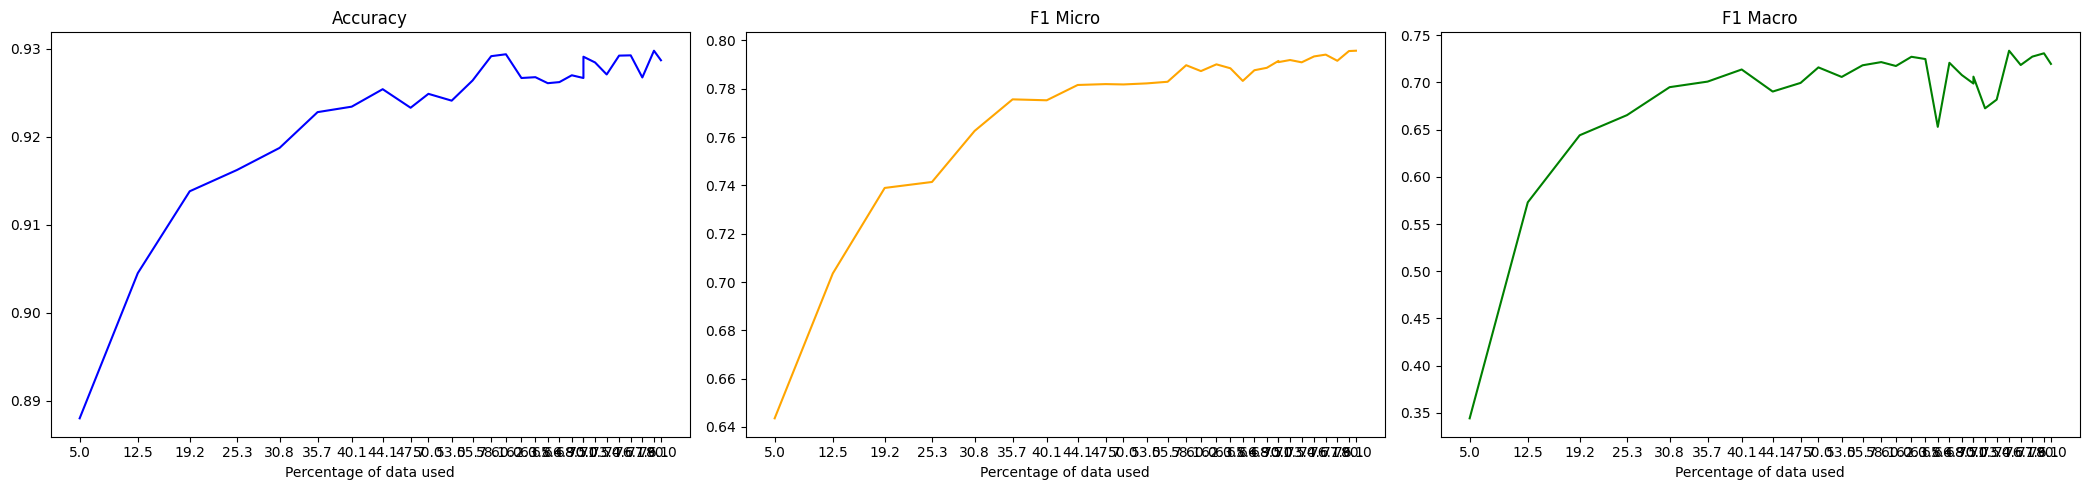

In [24]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5457, Accuracy: 0.8292, F1 Micro: 0.0597, F1 Macro: 0.0209
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4144, Accuracy: 0.8424, F1 Micro: 0.221, F1 Macro: 0.0713
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3893, Accuracy: 0.8443, F1 Micro: 0.2286, F1 Macro: 0.0808
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3533, Accuracy: 0.8603, F1 Micro: 0.4071, F1 Macro: 0.157
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3123, Accuracy: 0.8733, F1 Micro: 0.5274, F1 Macro: 0.2581
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2824, Accuracy: 0.8793, F1 Micro: 0.5722, F1 Macro: 0.2897
Epoch 7/10, Train Loss: 0.2589, Accuracy: 0.874, F1 Micro: 0.495, F1 Macro: 0.2627
Epoch 8/10, Train Loss: 0.2342, Accuracy: 0.881, F1 Micro: 0.5512, F1 Macro: 0.3126
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2061, Accuracy: 0.8889, F1 Micro: 0.6174, F1 Macro: 0.3491
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4792, Accuracy: 0.8171, F1 Micro: 0.5062, F1 Macro: 0.2233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3769, Accuracy: 0.8702, F1 Micro: 0.5836, F1 Macro: 0.2709
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3339, Accuracy: 0.8861, F1 Micro: 0.6229, F1 Macro: 0.309
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2856, Accuracy: 0.893, F1 Micro: 0.6475, F1 Macro: 0.3712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2469, Accuracy: 0.8962, F1 Micro: 0.6659, F1 Macro: 0.405
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2205, Accuracy: 0.899, F1 Micro: 0.6674, F1 Macro: 0.4377
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1919, Accuracy: 0.8995, F1 Micro: 0.6767, F1 Macro: 0.4465
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1646, Accuracy: 0.9004, F1 Micro: 0.6887, F1 Macro: 0.512
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.13

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4533, Accuracy: 0.8204, F1 Micro: 0.5118, F1 Macro: 0.2288
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3588, Accuracy: 0.8817, F1 Micro: 0.6434, F1 Macro: 0.3636
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2956, Accuracy: 0.8977, F1 Micro: 0.679, F1 Macro: 0.4468
Epoch 4/10, Train Loss: 0.2535, Accuracy: 0.9018, F1 Micro: 0.675, F1 Macro: 0.4703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2088, Accuracy: 0.9022, F1 Micro: 0.7186, F1 Macro: 0.5494
Epoch 6/10, Train Loss: 0.164, Accuracy: 0.9074, F1 Micro: 0.6968, F1 Macro: 0.5668
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1386, Accuracy: 0.9085, F1 Micro: 0.7221, F1 Macro: 0.606
Epoch 8/10, Train Loss: 0.1123, Accuracy: 0.9059, F1 Micro: 0.7199, F1 Macro: 0.6262
Epoch 9/10, Train Loss: 0.0996, Accuracy: 0.906, F1 Micro: 0.6931, F1 Macro: 0.6026
Epoch 10/10, Train Loss: 0.0878, Accuracy: 0.9056, F1 Micro: 0.7129, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4487, Accuracy: 0.8288, F1 Micro: 0.5627, F1 Macro: 0.2828
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3405, Accuracy: 0.8951, F1 Micro: 0.6912, F1 Macro: 0.4555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2801, Accuracy: 0.9048, F1 Micro: 0.7154, F1 Macro: 0.5169
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2303, Accuracy: 0.9133, F1 Micro: 0.721, F1 Macro: 0.5589
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1857, Accuracy: 0.9152, F1 Micro: 0.7334, F1 Macro: 0.6007
Epoch 6/10, Train Loss: 0.1507, Accuracy: 0.9141, F1 Micro: 0.7269, F1 Macro: 0.6125
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.125, Accuracy: 0.9159, F1 Micro: 0.7412, F1 Macro: 0.6405
Epoch 8/10, Train Loss: 0.0998, Accuracy: 0.9156, F1 Micro: 0.7383, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0887, Accuracy: 0.9159, F1 Micro: 0.7497, F1 Macro: 0.6746
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.444, Accuracy: 0.8534, F1 Micro: 0.5907, F1 Macro: 0.3322
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3266, Accuracy: 0.8979, F1 Micro: 0.7144, F1 Macro: 0.54
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2626, Accuracy: 0.9078, F1 Micro: 0.7377, F1 Macro: 0.587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2193, Accuracy: 0.9146, F1 Micro: 0.7407, F1 Macro: 0.5962
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1753, Accuracy: 0.9167, F1 Micro: 0.754, F1 Macro: 0.6344
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.137, Accuracy: 0.919, F1 Micro: 0.7638, F1 Macro: 0.6701
Epoch 7/10, Train Loss: 0.1178, Accuracy: 0.9163, F1 Micro: 0.7459, F1 Macro: 0.6665
Epoch 8/10, Train Loss: 0.0939, Accuracy: 0.9175, F1 Micro: 0.7481, F1 Macro: 0.6716
Epoch 9/10, Train Loss: 0.0834, Accuracy: 0.9155, F1 Micro: 0.7446, F1 Macro: 0.6784
Epoch 10/10, Train Loss: 0.0753, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4323, Accuracy: 0.8771, F1 Micro: 0.6347, F1 Macro: 0.4005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3171, Accuracy: 0.9074, F1 Micro: 0.7255, F1 Macro: 0.5565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2546, Accuracy: 0.9181, F1 Micro: 0.7493, F1 Macro: 0.5944
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2051, Accuracy: 0.9144, F1 Micro: 0.7591, F1 Macro: 0.6145
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1688, Accuracy: 0.9176, F1 Micro: 0.7618, F1 Macro: 0.6358
Epoch 6/10, Train Loss: 0.1399, Accuracy: 0.9203, F1 Micro: 0.7525, F1 Macro: 0.6507
Epoch 7/10, Train Loss: 0.1174, Accuracy: 0.9187, F1 Micro: 0.7556, F1 Macro: 0.6595
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0969, Accuracy: 0.9203, F1 Micro: 0.7684, F1 Macro: 0.6877
Epoch 9/10, Train Loss: 0.0836, Accuracy: 0.9179, F1 Micro: 0.7599, F1 Macro: 0.6845
Epoch 10/10, Train Loss: 0.0691, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4212, Accuracy: 0.8856, F1 Micro: 0.6639, F1 Macro: 0.4445
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3069, Accuracy: 0.9022, F1 Micro: 0.7311, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2434, Accuracy: 0.9165, F1 Micro: 0.7514, F1 Macro: 0.6139
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2064, Accuracy: 0.9192, F1 Micro: 0.7629, F1 Macro: 0.6307
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1608, Accuracy: 0.9202, F1 Micro: 0.764, F1 Macro: 0.6574
Epoch 6/10, Train Loss: 0.1348, Accuracy: 0.9214, F1 Micro: 0.759, F1 Macro: 0.6641
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.9213, F1 Micro: 0.7612, F1 Macro: 0.6786
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9214, F1 Micro: 0.7646, F1 Macro: 0.6912
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9211, F1 Micro: 0.772, F1 Macro: 0.6989
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4062, Accuracy: 0.8929, F1 Micro: 0.6699, F1 Macro: 0.4647
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2875, Accuracy: 0.9146, F1 Micro: 0.7376, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2278, Accuracy: 0.9177, F1 Micro: 0.7614, F1 Macro: 0.6075
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1858, Accuracy: 0.9235, F1 Micro: 0.7717, F1 Macro: 0.6317
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1491, Accuracy: 0.9201, F1 Micro: 0.7721, F1 Macro: 0.6528
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9244, F1 Micro: 0.7666, F1 Macro: 0.6649
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1006, Accuracy: 0.9198, F1 Micro: 0.7731, F1 Macro: 0.6827
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9242, F1 Micro: 0.7746, F1 Macro: 0.6944
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9239, F1 Micro: 0.7719, F1 Macro: 0.699
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3877, Accuracy: 0.8957, F1 Micro: 0.6983, F1 Macro: 0.4371
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.911, F1 Micro: 0.7459, F1 Macro: 0.5797
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2078, Accuracy: 0.9191, F1 Micro: 0.7507, F1 Macro: 0.6111
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9171, F1 Micro: 0.7684, F1 Macro: 0.6588
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.134, Accuracy: 0.9208, F1 Micro: 0.7714, F1 Macro: 0.6717
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.9232, F1 Micro: 0.769, F1 Macro: 0.6715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.9253, F1 Micro: 0.7754, F1 Macro: 0.679
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9197, F1 Micro: 0.7766, F1 Macro: 0.7014
Epoch 9/10, Train Loss: 0.0634, Accuracy: 0.9233, F1 Micro: 0.7706, F1 Macro: 0.7056
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3819, Accuracy: 0.898, F1 Micro: 0.6635, F1 Macro: 0.4495
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2603, Accuracy: 0.9123, F1 Micro: 0.7106, F1 Macro: 0.5405
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.919, F1 Micro: 0.7422, F1 Macro: 0.5925
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9227, F1 Micro: 0.769, F1 Macro: 0.6356
Epoch 5/10, Train Loss: 0.1376, Accuracy: 0.9232, F1 Micro: 0.7622, F1 Macro: 0.6415
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.9249, F1 Micro: 0.7788, F1 Macro: 0.6835
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.9204, F1 Micro: 0.7729, F1 Macro: 0.6933
Epoch 8/10, Train Loss: 0.0759, Accuracy: 0.9183, F1 Micro: 0.7652, F1 Macro: 0.6944
Epoch 9/10, Train Loss: 0.0614, Accuracy: 0.9227, F1 Micro: 0.7735, F1 Macro: 0.7009
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0538, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3707, Accuracy: 0.8996, F1 Micro: 0.6998, F1 Macro: 0.4821
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.9115, F1 Micro: 0.7409, F1 Macro: 0.5747
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9197, F1 Micro: 0.7609, F1 Macro: 0.6063
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9183, F1 Micro: 0.7681, F1 Macro: 0.6534
Epoch 5/10, Train Loss: 0.1293, Accuracy: 0.9238, F1 Micro: 0.7638, F1 Macro: 0.6615
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9206, F1 Micro: 0.7654, F1 Macro: 0.6825
Epoch 7/10, Train Loss: 0.0883, Accuracy: 0.9229, F1 Micro: 0.7587, F1 Macro: 0.6795
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9226, F1 Micro: 0.7724, F1 Macro: 0.681
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9231, F1 Micro: 0.7792, F1 Macro: 0.7083
Epoch 10/10, Train Loss: 0.0497, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3598, Accuracy: 0.9031, F1 Micro: 0.6935, F1 Macro: 0.4369
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2452, Accuracy: 0.9159, F1 Micro: 0.7418, F1 Macro: 0.5786
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1961, Accuracy: 0.9221, F1 Micro: 0.7623, F1 Macro: 0.6094
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9238, F1 Micro: 0.7761, F1 Macro: 0.6696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1237, Accuracy: 0.9244, F1 Micro: 0.778, F1 Macro: 0.6763
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9195, F1 Micro: 0.7749, F1 Macro: 0.6761
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9256, F1 Micro: 0.7803, F1 Macro: 0.6946
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.9258, F1 Micro: 0.7815, F1 Macro: 0.7128
Epoch 9/10, Train Loss: 0.0596, Accuracy: 0.9231, F1 Micro: 0.7701, F1 Macro: 0.7028
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3511, Accuracy: 0.9015, F1 Micro: 0.6889, F1 Macro: 0.4833
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2348, Accuracy: 0.9151, F1 Micro: 0.7486, F1 Macro: 0.5586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.9209, F1 Micro: 0.7528, F1 Macro: 0.6065
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1475, Accuracy: 0.9214, F1 Micro: 0.767, F1 Macro: 0.6305
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.9263, F1 Micro: 0.7819, F1 Macro: 0.6722
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.9247, F1 Micro: 0.7702, F1 Macro: 0.6838
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9171, F1 Micro: 0.7712, F1 Macro: 0.6943
Epoch 8/10, Train Loss: 0.0685, Accuracy: 0.9221, F1 Micro: 0.7651, F1 Macro: 0.6913
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9228, F1 Micro: 0.7802, F1 Macro: 0.7153
Epoch 10/10, Train Loss: 0.0459, Accuracy: 0.9218, F1 Micro: 0.7671, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3563, Accuracy: 0.9003, F1 Micro: 0.7026, F1 Macro: 0.4533
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2361, Accuracy: 0.9161, F1 Micro: 0.7279, F1 Macro: 0.5554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9227, F1 Micro: 0.7697, F1 Macro: 0.6361
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1489, Accuracy: 0.9239, F1 Micro: 0.781, F1 Macro: 0.6604
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.926, F1 Micro: 0.7835, F1 Macro: 0.6957
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.9232, F1 Micro: 0.7744, F1 Macro: 0.6925
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.9241, F1 Micro: 0.7767, F1 Macro: 0.7009
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9234, F1 Micro: 0.7754, F1 Macro: 0.7117
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.9245, F1 Micro: 0.7761, F1 Macro: 0.7125
Epoch 10/10, Train Loss: 0.0455, Accuracy: 0.9259, F1 Micro: 0.7823, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3406, Accuracy: 0.9035, F1 Micro: 0.7076, F1 Macro: 0.4931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2268, Accuracy: 0.9117, F1 Micro: 0.7424, F1 Macro: 0.5788
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1803, Accuracy: 0.9213, F1 Micro: 0.7554, F1 Macro: 0.6033
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1427, Accuracy: 0.9222, F1 Micro: 0.7666, F1 Macro: 0.6422
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9216, F1 Micro: 0.7785, F1 Macro: 0.6672
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.9249, F1 Micro: 0.7808, F1 Macro: 0.6937
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.9224, F1 Micro: 0.7816, F1 Macro: 0.7009
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9245, F1 Micro: 0.7866, F1 Macro: 0.7133
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9229, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3391, Accuracy: 0.9037, F1 Micro: 0.6902, F1 Macro: 0.4493
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2281, Accuracy: 0.9148, F1 Micro: 0.7539, F1 Macro: 0.5916
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.184, Accuracy: 0.9191, F1 Micro: 0.7638, F1 Macro: 0.638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1442, Accuracy: 0.9204, F1 Micro: 0.7715, F1 Macro: 0.6615
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1143, Accuracy: 0.9252, F1 Micro: 0.7752, F1 Macro: 0.6771
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9231, F1 Micro: 0.7745, F1 Macro: 0.6955
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9237, F1 Micro: 0.7713, F1 Macro: 0.7014
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9242, F1 Micro: 0.7829, F1 Macro: 0.7088
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9214, F1 Micro: 0.7681, F1 Macro: 0.7076
Epoch 10/10, Train Loss: 0.0434, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3377, Accuracy: 0.9002, F1 Micro: 0.7085, F1 Macro: 0.474
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2223, Accuracy: 0.9125, F1 Micro: 0.7522, F1 Macro: 0.5896
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1741, Accuracy: 0.9202, F1 Micro: 0.7665, F1 Macro: 0.6155
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.143, Accuracy: 0.9201, F1 Micro: 0.7736, F1 Macro: 0.6454
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1147, Accuracy: 0.9259, F1 Micro: 0.7829, F1 Macro: 0.665
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.926, F1 Micro: 0.7763, F1 Macro: 0.6984
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9241, F1 Micro: 0.7826, F1 Macro: 0.7041
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9204, F1 Micro: 0.7774, F1 Macro: 0.696
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9257, F1 Micro: 0.7822, F1 Macro: 0.7191
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0429, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3336, Accuracy: 0.9041, F1 Micro: 0.7084, F1 Macro: 0.485
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2204, Accuracy: 0.9171, F1 Micro: 0.7488, F1 Macro: 0.5899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9239, F1 Micro: 0.7655, F1 Macro: 0.6328
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.146, Accuracy: 0.9254, F1 Micro: 0.7754, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1124, Accuracy: 0.9274, F1 Micro: 0.7765, F1 Macro: 0.6618
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.9248, F1 Micro: 0.7783, F1 Macro: 0.6808
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9262, F1 Micro: 0.7836, F1 Macro: 0.7005
Epoch 8/10, Train Loss: 0.0595, Accuracy: 0.9245, F1 Micro: 0.7807, F1 Macro: 0.7074
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.9257, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3353, Accuracy: 0.9024, F1 Micro: 0.6627, F1 Macro: 0.4433
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2184, Accuracy: 0.918, F1 Micro: 0.7483, F1 Macro: 0.5811
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1714, Accuracy: 0.9226, F1 Micro: 0.7725, F1 Macro: 0.6185
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.137, Accuracy: 0.9257, F1 Micro: 0.7817, F1 Macro: 0.6719
Epoch 5/10, Train Loss: 0.1114, Accuracy: 0.924, F1 Micro: 0.7734, F1 Macro: 0.668
Epoch 6/10, Train Loss: 0.0905, Accuracy: 0.9205, F1 Micro: 0.7772, F1 Macro: 0.6891
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.9247, F1 Micro: 0.7813, F1 Macro: 0.6989
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9238, F1 Micro: 0.7823, F1 Macro: 0.7088
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9214, F1 Micro: 0.7775, F1 Macro: 0.7091
Epoch 10/10, Train Loss: 0.0448, Accuracy: 0.9237, F1 Micro: 0.7817, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3299, Accuracy: 0.9002, F1 Micro: 0.7187, F1 Macro: 0.5222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2203, Accuracy: 0.9173, F1 Micro: 0.76, F1 Macro: 0.5794
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.173, Accuracy: 0.9229, F1 Micro: 0.775, F1 Macro: 0.6235
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1373, Accuracy: 0.9252, F1 Micro: 0.7832, F1 Macro: 0.6734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1087, Accuracy: 0.9232, F1 Micro: 0.7838, F1 Macro: 0.684
Epoch 6/10, Train Loss: 0.0883, Accuracy: 0.9189, F1 Micro: 0.7773, F1 Macro: 0.6986
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.9259, F1 Micro: 0.7866, F1 Macro: 0.6979
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9261, F1 Micro: 0.781, F1 Macro: 0.7077
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9252, F1 Micro: 0.7751, F1 Macro: 0.709
Epoch 10/10, Train Loss: 0.0411, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3309, Accuracy: 0.8974, F1 Micro: 0.718, F1 Macro: 0.523
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2139, Accuracy: 0.9178, F1 Micro: 0.7595, F1 Macro: 0.5798
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1711, Accuracy: 0.9241, F1 Micro: 0.7745, F1 Macro: 0.6314
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1372, Accuracy: 0.9204, F1 Micro: 0.7773, F1 Macro: 0.6627
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1108, Accuracy: 0.9239, F1 Micro: 0.7827, F1 Macro: 0.6727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0846, Accuracy: 0.9235, F1 Micro: 0.7855, F1 Macro: 0.701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.9257, F1 Micro: 0.7862, F1 Macro: 0.7043
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.9255, F1 Micro: 0.7763, F1 Macro: 0.7014
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9259, F1 Micro: 0.7786, F1 Macro: 0.7142
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.326, Accuracy: 0.9052, F1 Micro: 0.6988, F1 Macro: 0.4842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2201, Accuracy: 0.9193, F1 Micro: 0.7549, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.171, Accuracy: 0.9245, F1 Micro: 0.7788, F1 Macro: 0.6349
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1359, Accuracy: 0.9261, F1 Micro: 0.7848, F1 Macro: 0.6692
Epoch 5/10, Train Loss: 0.1077, Accuracy: 0.9256, F1 Micro: 0.7678, F1 Macro: 0.6757
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9262, F1 Micro: 0.7829, F1 Macro: 0.6966
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9268, F1 Micro: 0.787, F1 Macro: 0.7107
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9276, F1 Micro: 0.7898, F1 Macro: 0.7174
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.9238, F1 Micro: 0.7846, F1 Macro: 0.7203
Epoch 10/10, Train Loss: 0.0422, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3248, Accuracy: 0.9038, F1 Micro: 0.677, F1 Macro: 0.4731
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2107, Accuracy: 0.9187, F1 Micro: 0.75, F1 Macro: 0.5932
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1726, Accuracy: 0.9237, F1 Micro: 0.7732, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1392, Accuracy: 0.9212, F1 Micro: 0.7786, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.112, Accuracy: 0.9244, F1 Micro: 0.785, F1 Macro: 0.6917
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0846, Accuracy: 0.9271, F1 Micro: 0.7881, F1 Macro: 0.6952
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.9249, F1 Micro: 0.7827, F1 Macro: 0.7154
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.9293, F1 Micro: 0.7938, F1 Macro: 0.7238
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9246, F1 Micro: 0.7796, F1 Macro: 0.7186
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3238, Accuracy: 0.9082, F1 Micro: 0.7052, F1 Macro: 0.4887
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2185, Accuracy: 0.9203, F1 Micro: 0.7436, F1 Macro: 0.5737
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1704, Accuracy: 0.9135, F1 Micro: 0.7648, F1 Macro: 0.6363
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.138, Accuracy: 0.9268, F1 Micro: 0.783, F1 Macro: 0.6611
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1068, Accuracy: 0.9276, F1 Micro: 0.787, F1 Macro: 0.6702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0851, Accuracy: 0.9259, F1 Micro: 0.7871, F1 Macro: 0.7067
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9273, F1 Micro: 0.7855, F1 Macro: 0.688
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9231, F1 Micro: 0.7862, F1 Macro: 0.7233
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.928, F1 Micro: 0.7885, F1 Macro: 0.728
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.322, Accuracy: 0.9076, F1 Micro: 0.6982, F1 Macro: 0.4858
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2147, Accuracy: 0.9207, F1 Micro: 0.7551, F1 Macro: 0.5835
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1679, Accuracy: 0.9257, F1 Micro: 0.7842, F1 Macro: 0.6555
Epoch 4/10, Train Loss: 0.136, Accuracy: 0.9265, F1 Micro: 0.774, F1 Macro: 0.6474
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.926, F1 Micro: 0.7815, F1 Macro: 0.6978
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.9259, F1 Micro: 0.7796, F1 Macro: 0.6966
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9286, F1 Micro: 0.7916, F1 Macro: 0.7185
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9262, F1 Micro: 0.7857, F1 Macro: 0.7197
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9258, F1 Micro: 0.7863, F1 Macro: 0.7201
Epoch 10/10, Train Loss: 0.0404, Accuracy: 0.9263, F1 Micro: 0.7817, F1 Macro: 0.7172

 Iteration 10018: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3232, Accuracy: 0.9043, F1 Micro: 0.6839, F1 Macro: 0.4478
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2155, Accuracy: 0.9227, F1 Micro: 0.761, F1 Macro: 0.5991
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1716, Accuracy: 0.9256, F1 Micro: 0.7739, F1 Macro: 0.6308
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.9261, F1 Micro: 0.7852, F1 Macro: 0.6673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1099, Accuracy: 0.9298, F1 Micro: 0.7875, F1 Macro: 0.6836
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.9271, F1 Micro: 0.7888, F1 Macro: 0.7063
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.9291, F1 Micro: 0.7893, F1 Macro: 0.7101
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9268, F1 Micro: 0.7869, F1 Macro: 0.7128
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.928, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3247, Accuracy: 0.9028, F1 Micro: 0.6664, F1 Macro: 0.4764
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2173, Accuracy: 0.9225, F1 Micro: 0.761, F1 Macro: 0.5963
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.9269, F1 Micro: 0.7836, F1 Macro: 0.644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1394, Accuracy: 0.9268, F1 Micro: 0.7897, F1 Macro: 0.6795
Epoch 5/10, Train Loss: 0.1107, Accuracy: 0.9283, F1 Micro: 0.7876, F1 Macro: 0.6945
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9295, F1 Micro: 0.788, F1 Macro: 0.6763
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.9282, F1 Micro: 0.7929, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9282, F1 Micro: 0.7959, F1 Macro: 0.7235
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9274, F1 Micro: 0.7914, F1 Macro: 0.7299
Epoch 10/10, Train Loss: 0.0414, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3208, Accuracy: 0.9085, F1 Micro: 0.7094, F1 Macro: 0.4694
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.212, Accuracy: 0.9212, F1 Micro: 0.7614, F1 Macro: 0.6027
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1705, Accuracy: 0.9251, F1 Micro: 0.7811, F1 Macro: 0.6617
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1347, Accuracy: 0.9285, F1 Micro: 0.7905, F1 Macro: 0.678
Epoch 5/10, Train Loss: 0.1067, Accuracy: 0.9278, F1 Micro: 0.7872, F1 Macro: 0.691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.93, F1 Micro: 0.7947, F1 Macro: 0.7195
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.9286, F1 Micro: 0.786, F1 Macro: 0.7139
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.9284, F1 Micro: 0.7862, F1 Macro: 0.7107
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9264, F1 Micro: 0.7851, F1 Macro: 0.7153
Epoch 10/10, Train Loss: 0.0411, Accuracy: 0.9222, F1 Micro: 0.7799, F1 Macro

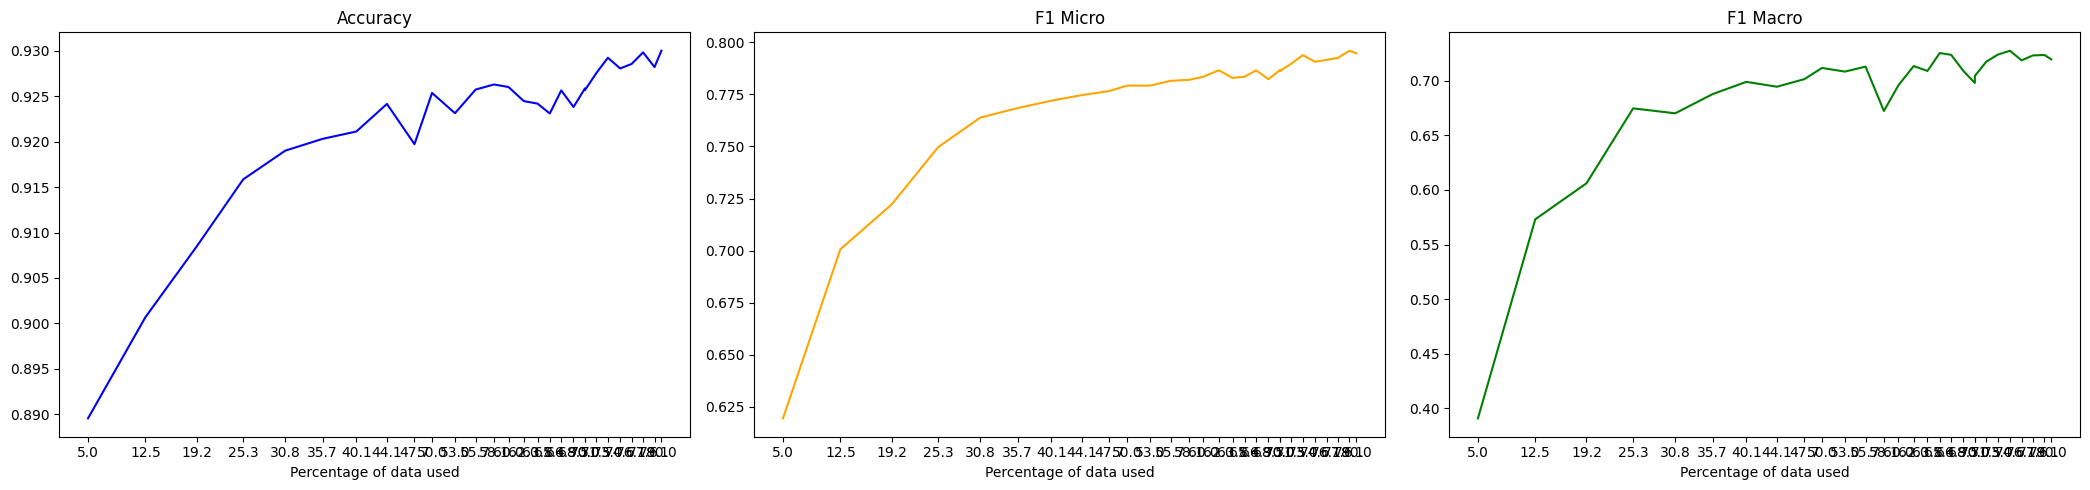

In [25]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5519, Accuracy: 0.828, F1 Micro: 0.0267, F1 Macro: 0.0113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4104, Accuracy: 0.8342, F1 Micro: 0.1087, F1 Macro: 0.0403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3709, Accuracy: 0.8448, F1 Micro: 0.2599, F1 Macro: 0.0878
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3484, Accuracy: 0.8632, F1 Micro: 0.4852, F1 Macro: 0.2064
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3341, Accuracy: 0.8732, F1 Micro: 0.5834, F1 Macro: 0.2692
Epoch 6/10, Train Loss: 0.2942, Accuracy: 0.8779, F1 Micro: 0.5622, F1 Macro: 0.2632
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2602, Accuracy: 0.8819, F1 Micro: 0.5948, F1 Macro: 0.285
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2414, Accuracy: 0.8842, F1 Micro: 0.6007, F1 Macro: 0.2979
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2191, Accuracy: 0.8873, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5268, Accuracy: 0.8178, F1 Micro: 0.2898, F1 Macro: 0.0607
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4305, Accuracy: 0.8698, F1 Micro: 0.542, F1 Macro: 0.3194
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3534, Accuracy: 0.8901, F1 Micro: 0.6227, F1 Macro: 0.4483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.306, Accuracy: 0.8992, F1 Micro: 0.6778, F1 Macro: 0.5331
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.254, Accuracy: 0.9026, F1 Micro: 0.6899, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2199, Accuracy: 0.9004, F1 Micro: 0.7115, F1 Macro: 0.573
Epoch 7/10, Train Loss: 0.1955, Accuracy: 0.9031, F1 Micro: 0.7091, F1 Macro: 0.5812
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.159, Accuracy: 0.9024, F1 Micro: 0.7121, F1 Macro: 0.5745
Epoch 9/10, Train Loss: 0.1293, Accuracy: 0.9017, F1 Micro: 0.7027, F1 Macro: 0.5759
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4944, Accuracy: 0.8254, F1 Micro: 0.5528, F1 Macro: 0.2685
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3721, Accuracy: 0.8818, F1 Micro: 0.6514, F1 Macro: 0.4403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3123, Accuracy: 0.8978, F1 Micro: 0.6946, F1 Macro: 0.5402
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2589, Accuracy: 0.9042, F1 Micro: 0.7001, F1 Macro: 0.5532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2162, Accuracy: 0.9085, F1 Micro: 0.7196, F1 Macro: 0.5862
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1804, Accuracy: 0.9091, F1 Micro: 0.7244, F1 Macro: 0.5988
Epoch 7/10, Train Loss: 0.1423, Accuracy: 0.9092, F1 Micro: 0.723, F1 Macro: 0.602
Epoch 8/10, Train Loss: 0.1198, Accuracy: 0.9078, F1 Micro: 0.7041, F1 Macro: 0.5901
Epoch 9/10, Train Loss: 0.0996, Accuracy: 0.9062, F1 Micro: 0.7217, F1 Macro: 0.614
Epoch 10/10, Train Loss: 0.0922, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4751, Accuracy: 0.8248, F1 Micro: 0.5675, F1 Macro: 0.2911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.363, Accuracy: 0.8964, F1 Micro: 0.6823, F1 Macro: 0.508
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2923, Accuracy: 0.9063, F1 Micro: 0.7094, F1 Macro: 0.5604
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2446, Accuracy: 0.9108, F1 Micro: 0.7383, F1 Macro: 0.5986
Epoch 5/10, Train Loss: 0.1989, Accuracy: 0.9143, F1 Micro: 0.7329, F1 Macro: 0.6018
Epoch 6/10, Train Loss: 0.1653, Accuracy: 0.9151, F1 Micro: 0.7357, F1 Macro: 0.6139
Epoch 7/10, Train Loss: 0.1294, Accuracy: 0.9122, F1 Micro: 0.7242, F1 Macro: 0.6174
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.115, Accuracy: 0.9129, F1 Micro: 0.7434, F1 Macro: 0.631
Epoch 9/10, Train Loss: 0.095, Accuracy: 0.9138, F1 Micro: 0.7394, F1 Macro: 0.6289
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0847, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4463, Accuracy: 0.878, F1 Micro: 0.5875, F1 Macro: 0.2983
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.322, Accuracy: 0.8985, F1 Micro: 0.7046, F1 Macro: 0.5263
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2533, Accuracy: 0.9107, F1 Micro: 0.726, F1 Macro: 0.5729
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.209, Accuracy: 0.9112, F1 Micro: 0.7419, F1 Macro: 0.6117
Epoch 5/10, Train Loss: 0.1653, Accuracy: 0.9147, F1 Micro: 0.7371, F1 Macro: 0.6234
Epoch 6/10, Train Loss: 0.1314, Accuracy: 0.9145, F1 Micro: 0.7308, F1 Macro: 0.6199
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1123, Accuracy: 0.9167, F1 Micro: 0.7467, F1 Macro: 0.6321
Epoch 8/10, Train Loss: 0.0954, Accuracy: 0.9145, F1 Micro: 0.739, F1 Macro: 0.6315
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.915, F1 Micro: 0.7352, F1 Macro: 0.6431
Epoch 10/10, Train Loss: 0.0713, Accuracy: 0.9098, F1 Micro: 0.7422, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4019, Accuracy: 0.8814, F1 Micro: 0.5743, F1 Macro: 0.3042
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.276, Accuracy: 0.902, F1 Micro: 0.6969, F1 Macro: 0.5222
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2184, Accuracy: 0.9142, F1 Micro: 0.7268, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9125, F1 Micro: 0.7454, F1 Macro: 0.6089
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9154, F1 Micro: 0.7369, F1 Macro: 0.6125
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.9116, F1 Micro: 0.7518, F1 Macro: 0.6329
Epoch 7/10, Train Loss: 0.0929, Accuracy: 0.9165, F1 Micro: 0.7434, F1 Macro: 0.626
Epoch 8/10, Train Loss: 0.0794, Accuracy: 0.9154, F1 Micro: 0.7375, F1 Macro: 0.6292
Epoch 9/10, Train Loss: 0.067, Accuracy: 0.917, F1 Micro: 0.7491, F1 Macro: 0.6352
Epoch 10/10, Train Loss: 0.0544, Accuracy: 0.9152, F1 Micro: 0.7428, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3848, Accuracy: 0.886, F1 Micro: 0.6376, F1 Macro: 0.3311
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2535, Accuracy: 0.8959, F1 Micro: 0.7026, F1 Macro: 0.5104
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.9088, F1 Micro: 0.7348, F1 Macro: 0.5761
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1567, Accuracy: 0.9156, F1 Micro: 0.7371, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9077, F1 Micro: 0.7391, F1 Macro: 0.5986
Epoch 6/10, Train Loss: 0.1067, Accuracy: 0.9142, F1 Micro: 0.7388, F1 Macro: 0.6163
Epoch 7/10, Train Loss: 0.0855, Accuracy: 0.9109, F1 Micro: 0.7371, F1 Macro: 0.6082
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9114, F1 Micro: 0.7458, F1 Macro: 0.6323
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9145, F1 Micro: 0.734, F1 Macro: 0.6287
Epoch 10/10, Train Loss: 0.0545, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3638, Accuracy: 0.8902, F1 Micro: 0.6505, F1 Macro: 0.3472
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2318, Accuracy: 0.9041, F1 Micro: 0.7125, F1 Macro: 0.5337
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1813, Accuracy: 0.9109, F1 Micro: 0.7402, F1 Macro: 0.5876
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1517, Accuracy: 0.9117, F1 Micro: 0.7433, F1 Macro: 0.6099
Epoch 5/10, Train Loss: 0.1171, Accuracy: 0.9119, F1 Micro: 0.7355, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9144, F1 Micro: 0.7487, F1 Macro: 0.6174
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.9135, F1 Micro: 0.7534, F1 Macro: 0.6312
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9071, F1 Micro: 0.7427, F1 Macro: 0.6297
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9175, F1 Micro: 0.7483, F1 Macro: 0.6351
Epoch 10/10, Train Loss: 0.0461, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3561, Accuracy: 0.8916, F1 Micro: 0.6179, F1 Macro: 0.3492
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2224, Accuracy: 0.9074, F1 Micro: 0.7055, F1 Macro: 0.5147
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9122, F1 Micro: 0.7333, F1 Macro: 0.5779
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1446, Accuracy: 0.9125, F1 Micro: 0.7445, F1 Macro: 0.605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1114, Accuracy: 0.9132, F1 Micro: 0.7556, F1 Macro: 0.627
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.9179, F1 Micro: 0.7504, F1 Macro: 0.6177
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.9182, F1 Micro: 0.7537, F1 Macro: 0.6339
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9184, F1 Micro: 0.7448, F1 Macro: 0.63
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9163, F1 Micro: 0.7664, F1 Macro: 0.6559
Epoch 10/10, Train Loss: 0.045, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3471, Accuracy: 0.8932, F1 Micro: 0.6504, F1 Macro: 0.3761
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2188, Accuracy: 0.9072, F1 Micro: 0.7177, F1 Macro: 0.5313
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1696, Accuracy: 0.9078, F1 Micro: 0.7436, F1 Macro: 0.6012
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9187, F1 Micro: 0.7503, F1 Macro: 0.6163
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1129, Accuracy: 0.9182, F1 Micro: 0.7507, F1 Macro: 0.6267
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.9184, F1 Micro: 0.7551, F1 Macro: 0.6329
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9184, F1 Micro: 0.7551, F1 Macro: 0.6296
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.92, F1 Micro: 0.7583, F1 Macro: 0.637
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3373, Accuracy: 0.8893, F1 Micro: 0.5885, F1 Macro: 0.3358
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2133, Accuracy: 0.9104, F1 Micro: 0.7049, F1 Macro: 0.5339
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1631, Accuracy: 0.9159, F1 Micro: 0.7443, F1 Macro: 0.6082
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.138, Accuracy: 0.9129, F1 Micro: 0.7452, F1 Macro: 0.6021
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1125, Accuracy: 0.9192, F1 Micro: 0.7483, F1 Macro: 0.6198
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0823, Accuracy: 0.9184, F1 Micro: 0.7652, F1 Macro: 0.6305
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9191, F1 Micro: 0.7518, F1 Macro: 0.627
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9177, F1 Micro: 0.7464, F1 Macro: 0.6378
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9175, F1 Micro: 0.7565, F1 Macro: 0.6522
Epoch 10/10, Train Loss: 0.045, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3335, Accuracy: 0.8968, F1 Micro: 0.6647, F1 Macro: 0.4259
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2151, Accuracy: 0.9089, F1 Micro: 0.7227, F1 Macro: 0.5596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1685, Accuracy: 0.9109, F1 Micro: 0.7476, F1 Macro: 0.5968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1367, Accuracy: 0.9195, F1 Micro: 0.7595, F1 Macro: 0.6219
Epoch 5/10, Train Loss: 0.1059, Accuracy: 0.9166, F1 Micro: 0.7564, F1 Macro: 0.6271
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.9211, F1 Micro: 0.7631, F1 Macro: 0.6289
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9166, F1 Micro: 0.7618, F1 Macro: 0.6353
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9187, F1 Micro: 0.7595, F1 Macro: 0.6672
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9172, F1 Micro: 0.7583, F1 Macro: 0.657
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.9186, F1 Micro: 0.7554, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3409, Accuracy: 0.8973, F1 Micro: 0.6569, F1 Macro: 0.3945
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2158, Accuracy: 0.9109, F1 Micro: 0.7106, F1 Macro: 0.553
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1756, Accuracy: 0.9147, F1 Micro: 0.7525, F1 Macro: 0.6043
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.9219, F1 Micro: 0.7635, F1 Macro: 0.62
Epoch 5/10, Train Loss: 0.1077, Accuracy: 0.9195, F1 Micro: 0.7511, F1 Macro: 0.6212
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.923, F1 Micro: 0.7641, F1 Macro: 0.6612
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.924, F1 Micro: 0.7672, F1 Macro: 0.6554
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9165, F1 Micro: 0.7636, F1 Macro: 0.66
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9219, F1 Micro: 0.7686, F1 Macro: 0.6725
Higher F1 achi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3437, Accuracy: 0.895, F1 Micro: 0.6934, F1 Macro: 0.4488
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2187, Accuracy: 0.9096, F1 Micro: 0.7355, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1764, Accuracy: 0.9162, F1 Micro: 0.7608, F1 Macro: 0.6144
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1423, Accuracy: 0.9227, F1 Micro: 0.7621, F1 Macro: 0.6337
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1116, Accuracy: 0.9214, F1 Micro: 0.7704, F1 Macro: 0.65
Epoch 6/10, Train Loss: 0.0896, Accuracy: 0.9224, F1 Micro: 0.7586, F1 Macro: 0.6528
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9201, F1 Micro: 0.77, F1 Macro: 0.6846
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.9208, F1 Micro: 0.7707, F1 Macro: 0.6755
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9226, F1 Micro: 0.7671, F1 Macro: 0.6827
Epoch 10/10, Train Loss: 0.0444, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3345, Accuracy: 0.9006, F1 Micro: 0.6805, F1 Macro: 0.4409
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2173, Accuracy: 0.9154, F1 Micro: 0.7259, F1 Macro: 0.5553
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1699, Accuracy: 0.9211, F1 Micro: 0.7481, F1 Macro: 0.6044
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1324, Accuracy: 0.9158, F1 Micro: 0.7643, F1 Macro: 0.6429
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1071, Accuracy: 0.925, F1 Micro: 0.7733, F1 Macro: 0.6782
Epoch 6/10, Train Loss: 0.084, Accuracy: 0.9221, F1 Micro: 0.7644, F1 Macro: 0.6443
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.9169, F1 Micro: 0.7679, F1 Macro: 0.6945
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9228, F1 Micro: 0.7682, F1 Macro: 0.6821
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9245, F1 Micro: 0.7743, F1 Macro: 0.7001
Epoch 10/10, Train Loss: 0.0407, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3348, Accuracy: 0.9011, F1 Micro: 0.6848, F1 Macro: 0.4147
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2196, Accuracy: 0.9125, F1 Micro: 0.7464, F1 Macro: 0.5773
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1722, Accuracy: 0.9189, F1 Micro: 0.7571, F1 Macro: 0.6208
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1365, Accuracy: 0.9222, F1 Micro: 0.7738, F1 Macro: 0.6643
Epoch 5/10, Train Loss: 0.1116, Accuracy: 0.9245, F1 Micro: 0.7661, F1 Macro: 0.6629
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.9239, F1 Micro: 0.777, F1 Macro: 0.6882
Epoch 7/10, Train Loss: 0.0703, Accuracy: 0.9177, F1 Micro: 0.7727, F1 Macro: 0.6951
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9245, F1 Micro: 0.7738, F1 Macro: 0.7027
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9253, F1 Micro: 0.7766, F1 Macro: 0.6973
Epoch 10/10, Train Loss: 0.0419, Accuracy: 0.9234, F1 Micro: 0.7717, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3343, Accuracy: 0.9, F1 Micro: 0.6935, F1 Macro: 0.4496
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2201, Accuracy: 0.9158, F1 Micro: 0.7426, F1 Macro: 0.575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1719, Accuracy: 0.9205, F1 Micro: 0.7678, F1 Macro: 0.6496
Epoch 4/10, Train Loss: 0.1381, Accuracy: 0.9181, F1 Micro: 0.7635, F1 Macro: 0.6651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1084, Accuracy: 0.9248, F1 Micro: 0.7745, F1 Macro: 0.686
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0853, Accuracy: 0.9197, F1 Micro: 0.775, F1 Macro: 0.6942
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9256, F1 Micro: 0.7721, F1 Macro: 0.6911
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9246, F1 Micro: 0.7785, F1 Macro: 0.7059
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.9251, F1 Micro: 0.776, F1 Macro: 0.7108
Epoch 10/10, Train Loss: 0.0397, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3355, Accuracy: 0.8939, F1 Micro: 0.6953, F1 Macro: 0.4474
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2207, Accuracy: 0.9162, F1 Micro: 0.7433, F1 Macro: 0.5743
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1749, Accuracy: 0.9215, F1 Micro: 0.7509, F1 Macro: 0.6203
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1386, Accuracy: 0.9244, F1 Micro: 0.7738, F1 Macro: 0.6624
Epoch 5/10, Train Loss: 0.1082, Accuracy: 0.9235, F1 Micro: 0.7728, F1 Macro: 0.6725
Epoch 6/10, Train Loss: 0.0854, Accuracy: 0.9239, F1 Micro: 0.7711, F1 Macro: 0.6947
Epoch 7/10, Train Loss: 0.0718, Accuracy: 0.9222, F1 Micro: 0.7684, F1 Macro: 0.6907
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.9219, F1 Micro: 0.7776, F1 Macro: 0.7011
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9217, F1 Micro: 0.7752, F1 Macro: 0.7101
Epoch 10/10, Train Loss: 0.042, Accuracy: 0.9231, F1 Micro: 0.7758, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3319, Accuracy: 0.9026, F1 Micro: 0.7026, F1 Macro: 0.4705
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2169, Accuracy: 0.9146, F1 Micro: 0.7525, F1 Macro: 0.5923
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1711, Accuracy: 0.9234, F1 Micro: 0.7628, F1 Macro: 0.6312
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1338, Accuracy: 0.925, F1 Micro: 0.7723, F1 Macro: 0.6396
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.9254, F1 Micro: 0.7844, F1 Macro: 0.6926
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.9266, F1 Micro: 0.7804, F1 Macro: 0.6909
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9206, F1 Micro: 0.7748, F1 Macro: 0.6999
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9226, F1 Micro: 0.781, F1 Macro: 0.7111
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9251, F1 Micro: 0.7806, F1 Macro: 0.7093
Epoch 10/10, Train Loss: 0.045, Accuracy: 0.9198, F1 Micro: 0.7765, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3271, Accuracy: 0.9026, F1 Micro: 0.7084, F1 Macro: 0.4852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2131, Accuracy: 0.9182, F1 Micro: 0.7404, F1 Macro: 0.5633
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1665, Accuracy: 0.9213, F1 Micro: 0.7697, F1 Macro: 0.6352
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1336, Accuracy: 0.9208, F1 Micro: 0.7778, F1 Macro: 0.6585
Epoch 5/10, Train Loss: 0.1067, Accuracy: 0.926, F1 Micro: 0.7706, F1 Macro: 0.6598
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.9242, F1 Micro: 0.7763, F1 Macro: 0.6862
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9256, F1 Micro: 0.7846, F1 Macro: 0.7089
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9272, F1 Micro: 0.7814, F1 Macro: 0.7089
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9268, F1 Micro: 0.7769, F1 Macro: 0.7006
Epoch 10/10, Train Loss: 0.042, Accuracy: 0.9275, F1 Micro: 0.7776, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3354, Accuracy: 0.9027, F1 Micro: 0.7115, F1 Macro: 0.5011
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2147, Accuracy: 0.9176, F1 Micro: 0.7455, F1 Macro: 0.5677
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1658, Accuracy: 0.9213, F1 Micro: 0.7729, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1344, Accuracy: 0.9249, F1 Micro: 0.7814, F1 Macro: 0.6723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1054, Accuracy: 0.9254, F1 Micro: 0.7861, F1 Macro: 0.685
Epoch 6/10, Train Loss: 0.0831, Accuracy: 0.9268, F1 Micro: 0.7794, F1 Macro: 0.6927
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9246, F1 Micro: 0.7861, F1 Macro: 0.7122
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.927, F1 Micro: 0.7814, F1 Macro: 0.7012
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9242, F1 Micro: 0.7816, F1 Macro: 0.7091
Epoch 10/10, Train Loss: 0.0419, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.328, Accuracy: 0.8991, F1 Micro: 0.7047, F1 Macro: 0.4679
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2131, Accuracy: 0.9175, F1 Micro: 0.7537, F1 Macro: 0.5805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1649, Accuracy: 0.9236, F1 Micro: 0.7784, F1 Macro: 0.6473
Epoch 4/10, Train Loss: 0.1323, Accuracy: 0.9245, F1 Micro: 0.774, F1 Macro: 0.6592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1023, Accuracy: 0.9264, F1 Micro: 0.7789, F1 Macro: 0.6653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.928, F1 Micro: 0.7822, F1 Macro: 0.687
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9261, F1 Micro: 0.7881, F1 Macro: 0.7046
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.9287, F1 Micro: 0.786, F1 Macro: 0.7106
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.9247, F1 Micro: 0.7855, F1 Macro: 0.7119
Epoch 10/10, Train Loss: 0.04, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3292, Accuracy: 0.9059, F1 Micro: 0.7034, F1 Macro: 0.49
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.212, Accuracy: 0.9189, F1 Micro: 0.7642, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1665, Accuracy: 0.9225, F1 Micro: 0.7798, F1 Macro: 0.644
Epoch 4/10, Train Loss: 0.1316, Accuracy: 0.9232, F1 Micro: 0.7778, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1066, Accuracy: 0.9227, F1 Micro: 0.7831, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0813, Accuracy: 0.9266, F1 Micro: 0.7838, F1 Macro: 0.7014
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.9217, F1 Micro: 0.7824, F1 Macro: 0.7058
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9253, F1 Micro: 0.7836, F1 Macro: 0.7132
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.9256, F1 Micro: 0.7851, F1 Macro: 0.7093
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3258, Accuracy: 0.9035, F1 Micro: 0.6733, F1 Macro: 0.4691
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2132, Accuracy: 0.9198, F1 Micro: 0.7433, F1 Macro: 0.5726
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1652, Accuracy: 0.9269, F1 Micro: 0.7828, F1 Macro: 0.6394
Epoch 4/10, Train Loss: 0.1315, Accuracy: 0.9201, F1 Micro: 0.7784, F1 Macro: 0.6533
Epoch 5/10, Train Loss: 0.1046, Accuracy: 0.9269, F1 Micro: 0.7824, F1 Macro: 0.6719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0849, Accuracy: 0.9228, F1 Micro: 0.785, F1 Macro: 0.703
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9261, F1 Micro: 0.7859, F1 Macro: 0.6931
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9218, F1 Micro: 0.7816, F1 Macro: 0.7173
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9292, F1 Micro: 0.7927, F1 Macro: 0.7251
Epoch 10/10, Train Loss: 0.0399, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3277, Accuracy: 0.9083, F1 Micro: 0.7157, F1 Macro: 0.4964
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2112, Accuracy: 0.9173, F1 Micro: 0.7432, F1 Macro: 0.5626
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1695, Accuracy: 0.9277, F1 Micro: 0.7824, F1 Macro: 0.6535
Epoch 4/10, Train Loss: 0.1336, Accuracy: 0.9222, F1 Micro: 0.781, F1 Macro: 0.6613
Epoch 5/10, Train Loss: 0.1104, Accuracy: 0.9269, F1 Micro: 0.7813, F1 Macro: 0.6582
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0832, Accuracy: 0.9304, F1 Micro: 0.7914, F1 Macro: 0.701
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.925, F1 Micro: 0.7891, F1 Macro: 0.716
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9309, F1 Micro: 0.795, F1 Macro: 0.7241
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.927, F1 Micro: 0.7859, F1 Macro: 0.7121
Epoch 10/10, Train Loss: 0.0404, Accuracy: 0.9274, F1 Micro: 0.7872, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3272, Accuracy: 0.9062, F1 Micro: 0.6999, F1 Macro: 0.4827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2123, Accuracy: 0.9213, F1 Micro: 0.7635, F1 Macro: 0.5704
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1656, Accuracy: 0.9227, F1 Micro: 0.7712, F1 Macro: 0.6351
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1361, Accuracy: 0.9254, F1 Micro: 0.7823, F1 Macro: 0.6484
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1034, Accuracy: 0.9275, F1 Micro: 0.7863, F1 Macro: 0.6949
Epoch 6/10, Train Loss: 0.0841, Accuracy: 0.9276, F1 Micro: 0.7737, F1 Macro: 0.7022
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.9258, F1 Micro: 0.7867, F1 Macro: 0.7089
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.9296, F1 Micro: 0.7939, F1 Macro: 0.7175
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9277, F1 Micro: 0.782, F1 Macro: 0.7166
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3255, Accuracy: 0.9021, F1 Micro: 0.6601, F1 Macro: 0.4659
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2183, Accuracy: 0.9191, F1 Micro: 0.7522, F1 Macro: 0.5632
Epoch 3/10, Train Loss: 0.1729, Accuracy: 0.9213, F1 Micro: 0.7488, F1 Macro: 0.5971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1384, Accuracy: 0.9265, F1 Micro: 0.779, F1 Macro: 0.6624
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1065, Accuracy: 0.928, F1 Micro: 0.786, F1 Macro: 0.6841
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0845, Accuracy: 0.9302, F1 Micro: 0.7873, F1 Macro: 0.7122
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9272, F1 Micro: 0.7875, F1 Macro: 0.719
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.9292, F1 Micro: 0.7893, F1 Macro: 0.7225
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9284, F1 Micro: 0.7856, F1 Macro: 0.7206
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3267, Accuracy: 0.9033, F1 Micro: 0.6686, F1 Macro: 0.4255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2158, Accuracy: 0.918, F1 Micro: 0.7638, F1 Macro: 0.5955
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.169, Accuracy: 0.924, F1 Micro: 0.7778, F1 Macro: 0.64
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1335, Accuracy: 0.9264, F1 Micro: 0.784, F1 Macro: 0.6868
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.9256, F1 Micro: 0.7787, F1 Macro: 0.6931
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.085, Accuracy: 0.9265, F1 Micro: 0.7873, F1 Macro: 0.7093
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9256, F1 Micro: 0.7847, F1 Macro: 0.7183
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.9266, F1 Micro: 0.7864, F1 Macro: 0.7214
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9279, F1 Micro: 0.7878, F1 Macro: 0.7246
Epoch 10/10, Train Loss: 0.0407, Accuracy: 0

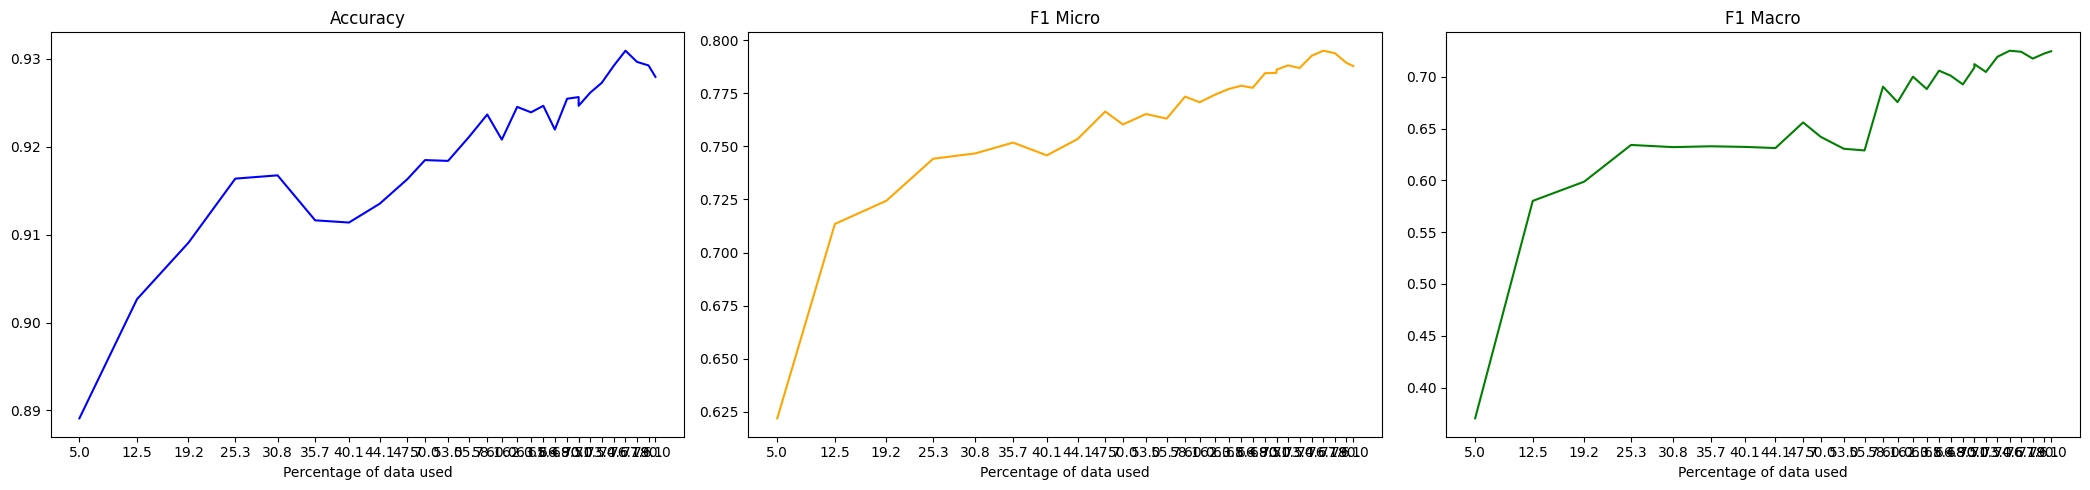

In [26]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5555, Accuracy: 0.8337, F1 Micro: 0.1221, F1 Macro: 0.0455
Epoch 2/10, Train Loss: 0.412, Accuracy: 0.8331, F1 Micro: 0.093, F1 Macro: 0.0357
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3838, Accuracy: 0.85, F1 Micro: 0.3324, F1 Macro: 0.1045
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.361, Accuracy: 0.8623, F1 Micro: 0.4364, F1 Macro: 0.1744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3354, Accuracy: 0.8743, F1 Micro: 0.5172, F1 Macro: 0.2393
Epoch 6/10, Train Loss: 0.2895, Accuracy: 0.8755, F1 Micro: 0.5149, F1 Macro: 0.2388
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2746, Accuracy: 0.8809, F1 Micro: 0.5603, F1 Macro: 0.2862
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2369, Accuracy: 0.8823, F1 Micro: 0.5656, F1 Macro: 0.3136
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2069, Accuracy: 0.8868, F1 Micro: 0.619, F1 Macro: 0.3533
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5024, Accuracy: 0.8093, F1 Micro: 0.5139, F1 Macro: 0.2273
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.398, Accuracy: 0.8787, F1 Micro: 0.5982, F1 Macro: 0.3505
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3359, Accuracy: 0.893, F1 Micro: 0.6657, F1 Macro: 0.4425
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2856, Accuracy: 0.8993, F1 Micro: 0.6766, F1 Macro: 0.491
Epoch 5/10, Train Loss: 0.2443, Accuracy: 0.9005, F1 Micro: 0.6606, F1 Macro: 0.4652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2112, Accuracy: 0.9014, F1 Micro: 0.6876, F1 Macro: 0.5289
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1792, Accuracy: 0.9016, F1 Micro: 0.688, F1 Macro: 0.5415
Epoch 8/10, Train Loss: 0.1545, Accuracy: 0.9004, F1 Micro: 0.6797, F1 Macro: 0.5549
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1313, Accuracy: 0.8987, F1 Micro: 0.7052, F1 Macro: 0.5675
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4771, Accuracy: 0.8223, F1 Micro: 0.527, F1 Macro: 0.2786
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3673, Accuracy: 0.8895, F1 Micro: 0.6643, F1 Macro: 0.4561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3004, Accuracy: 0.9005, F1 Micro: 0.6942, F1 Macro: 0.5059
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2546, Accuracy: 0.8992, F1 Micro: 0.7172, F1 Macro: 0.5686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.215, Accuracy: 0.909, F1 Micro: 0.7189, F1 Macro: 0.5639
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1822, Accuracy: 0.9098, F1 Micro: 0.7241, F1 Macro: 0.5793
Epoch 7/10, Train Loss: 0.1452, Accuracy: 0.9081, F1 Micro: 0.7237, F1 Macro: 0.589
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1221, Accuracy: 0.9102, F1 Micro: 0.7311, F1 Macro: 0.6137
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1051, Accuracy: 0.9104, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.466, Accuracy: 0.8183, F1 Micro: 0.568, F1 Macro: 0.3217
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3497, Accuracy: 0.8825, F1 Micro: 0.6844, F1 Macro: 0.5334
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2864, Accuracy: 0.9043, F1 Micro: 0.7151, F1 Macro: 0.5725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2435, Accuracy: 0.9078, F1 Micro: 0.7362, F1 Macro: 0.5951
Epoch 5/10, Train Loss: 0.1969, Accuracy: 0.9106, F1 Micro: 0.7358, F1 Macro: 0.5928
Epoch 6/10, Train Loss: 0.1602, Accuracy: 0.9088, F1 Micro: 0.7324, F1 Macro: 0.6202
Epoch 7/10, Train Loss: 0.1313, Accuracy: 0.9143, F1 Micro: 0.7348, F1 Macro: 0.6345
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1114, Accuracy: 0.9111, F1 Micro: 0.7384, F1 Macro: 0.643
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0953, Accuracy: 0.9158, F1 Micro: 0.7403, F1 Macro: 0.6484
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4567, Accuracy: 0.8454, F1 Micro: 0.5929, F1 Macro: 0.4047
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3431, Accuracy: 0.8983, F1 Micro: 0.7024, F1 Macro: 0.5468
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2777, Accuracy: 0.9112, F1 Micro: 0.7318, F1 Macro: 0.5768
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2359, Accuracy: 0.9159, F1 Micro: 0.7463, F1 Macro: 0.6219
Epoch 5/10, Train Loss: 0.1907, Accuracy: 0.9128, F1 Micro: 0.7299, F1 Macro: 0.6181
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1526, Accuracy: 0.914, F1 Micro: 0.7508, F1 Macro: 0.6567
Epoch 7/10, Train Loss: 0.1269, Accuracy: 0.9076, F1 Micro: 0.7406, F1 Macro: 0.6656
Epoch 8/10, Train Loss: 0.1102, Accuracy: 0.9151, F1 Micro: 0.7451, F1 Macro: 0.6699
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.091, Accuracy: 0.9153, F1 Micro: 0.753, F1 Macro: 0.6704
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4513, Accuracy: 0.849, F1 Micro: 0.6053, F1 Macro: 0.4029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3425, Accuracy: 0.9016, F1 Micro: 0.7093, F1 Macro: 0.5564
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.277, Accuracy: 0.9071, F1 Micro: 0.7398, F1 Macro: 0.5991
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2265, Accuracy: 0.915, F1 Micro: 0.7595, F1 Macro: 0.6343
Epoch 5/10, Train Loss: 0.1892, Accuracy: 0.9198, F1 Micro: 0.7563, F1 Macro: 0.6504
Epoch 6/10, Train Loss: 0.1541, Accuracy: 0.9202, F1 Micro: 0.7524, F1 Macro: 0.6606
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1243, Accuracy: 0.9186, F1 Micro: 0.7656, F1 Macro: 0.6882
Epoch 8/10, Train Loss: 0.1087, Accuracy: 0.9158, F1 Micro: 0.7488, F1 Macro: 0.6854
Epoch 9/10, Train Loss: 0.0901, Accuracy: 0.9208, F1 Micro: 0.7629, F1 Macro: 0.7027
Epoch 10/10, Train Loss: 0.0752, Accuracy: 0.9185, F1 Micro: 0.7618, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4388, Accuracy: 0.872, F1 Micro: 0.6315, F1 Macro: 0.3444
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3325, Accuracy: 0.9088, F1 Micro: 0.7239, F1 Macro: 0.5686
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2727, Accuracy: 0.9186, F1 Micro: 0.7465, F1 Macro: 0.6058
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2214, Accuracy: 0.9195, F1 Micro: 0.761, F1 Macro: 0.6599
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1845, Accuracy: 0.9183, F1 Micro: 0.7639, F1 Macro: 0.6445
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1418, Accuracy: 0.9227, F1 Micro: 0.7683, F1 Macro: 0.6781
Epoch 7/10, Train Loss: 0.1203, Accuracy: 0.9201, F1 Micro: 0.7671, F1 Macro: 0.6966
Epoch 8/10, Train Loss: 0.0988, Accuracy: 0.9219, F1 Micro: 0.7642, F1 Macro: 0.6992
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0851, Accuracy: 0.9229, F1 Micro: 0.776, F1 Macro: 0.7045
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4304, Accuracy: 0.8727, F1 Micro: 0.6634, F1 Macro: 0.4729
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3224, Accuracy: 0.9135, F1 Micro: 0.7331, F1 Macro: 0.5872
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2614, Accuracy: 0.9187, F1 Micro: 0.7559, F1 Macro: 0.6114
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2091, Accuracy: 0.9227, F1 Micro: 0.7619, F1 Macro: 0.628
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1727, Accuracy: 0.917, F1 Micro: 0.7682, F1 Macro: 0.6658
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1383, Accuracy: 0.9243, F1 Micro: 0.7791, F1 Macro: 0.6889
Epoch 7/10, Train Loss: 0.1133, Accuracy: 0.9218, F1 Micro: 0.7706, F1 Macro: 0.6962
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.9241, F1 Micro: 0.7737, F1 Macro: 0.6961
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9255, F1 Micro: 0.7717, F1 Macro: 0.6956
Epoch 10/10, Train Loss: 0.069, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4243, Accuracy: 0.8964, F1 Micro: 0.6777, F1 Macro: 0.4596
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.309, Accuracy: 0.9178, F1 Micro: 0.7452, F1 Macro: 0.5858
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2445, Accuracy: 0.9209, F1 Micro: 0.7499, F1 Macro: 0.59
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2033, Accuracy: 0.9167, F1 Micro: 0.7661, F1 Macro: 0.6457
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1646, Accuracy: 0.9236, F1 Micro: 0.7789, F1 Macro: 0.6957
Epoch 6/10, Train Loss: 0.1262, Accuracy: 0.9252, F1 Micro: 0.7671, F1 Macro: 0.6717
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.9209, F1 Micro: 0.7755, F1 Macro: 0.6998
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0923, Accuracy: 0.9269, F1 Micro: 0.7829, F1 Macro: 0.7076
Epoch 9/10, Train Loss: 0.0756, Accuracy: 0.9204, F1 Micro: 0.7765, F1 Macro: 0.7073
Epoch 10/10, Train Loss: 0.0713, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4176, Accuracy: 0.8821, F1 Micro: 0.6809, F1 Macro: 0.489
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3041, Accuracy: 0.9128, F1 Micro: 0.7244, F1 Macro: 0.542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2465, Accuracy: 0.9217, F1 Micro: 0.7501, F1 Macro: 0.5978
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1965, Accuracy: 0.9219, F1 Micro: 0.7768, F1 Macro: 0.6658
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1626, Accuracy: 0.9267, F1 Micro: 0.7794, F1 Macro: 0.6784
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9245, F1 Micro: 0.7795, F1 Macro: 0.6828
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.9274, F1 Micro: 0.7838, F1 Macro: 0.6996
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9257, F1 Micro: 0.7787, F1 Macro: 0.7089
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0.9249, F1 Micro: 0.7835, F1 Macro: 0.7134
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4125, Accuracy: 0.8977, F1 Micro: 0.6686, F1 Macro: 0.4803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2945, Accuracy: 0.9166, F1 Micro: 0.754, F1 Macro: 0.582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2368, Accuracy: 0.9208, F1 Micro: 0.7709, F1 Macro: 0.6199
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1916, Accuracy: 0.9236, F1 Micro: 0.775, F1 Macro: 0.6684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1564, Accuracy: 0.9269, F1 Micro: 0.7842, F1 Macro: 0.6931
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1253, Accuracy: 0.9271, F1 Micro: 0.7858, F1 Macro: 0.6921
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0983, Accuracy: 0.9269, F1 Micro: 0.7888, F1 Macro: 0.7144
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.9256, F1 Micro: 0.7795, F1 Macro: 0.7068
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0.9253, F1 Micro: 0.7808, F1 Macro: 0.7124
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3957, Accuracy: 0.8981, F1 Micro: 0.6649, F1 Macro: 0.4152
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2793, Accuracy: 0.919, F1 Micro: 0.7533, F1 Macro: 0.5959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2253, Accuracy: 0.921, F1 Micro: 0.7731, F1 Macro: 0.6222
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.9252, F1 Micro: 0.7756, F1 Macro: 0.6599
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1479, Accuracy: 0.9242, F1 Micro: 0.7795, F1 Macro: 0.6942
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.9275, F1 Micro: 0.7894, F1 Macro: 0.7001
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9251, F1 Micro: 0.7821, F1 Macro: 0.7088
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9271, F1 Micro: 0.7812, F1 Macro: 0.7179
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.9279, F1 Micro: 0.7825, F1 Macro: 0.7173
Epoch 10/10, Train Loss: 0.0609, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3895, Accuracy: 0.9039, F1 Micro: 0.6819, F1 Macro: 0.4471
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2709, Accuracy: 0.9137, F1 Micro: 0.7545, F1 Macro: 0.6051
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2176, Accuracy: 0.9226, F1 Micro: 0.7701, F1 Macro: 0.6287
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1768, Accuracy: 0.9288, F1 Micro: 0.7843, F1 Macro: 0.6911
Epoch 5/10, Train Loss: 0.1387, Accuracy: 0.9277, F1 Micro: 0.784, F1 Macro: 0.6912
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.9243, F1 Micro: 0.7836, F1 Macro: 0.706
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.927, F1 Micro: 0.7837, F1 Macro: 0.7025
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9263, F1 Micro: 0.7889, F1 Macro: 0.725
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0665, Accuracy: 0.9272, F1 Micro: 0.7942, F1 Macro: 0.7333
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3804, Accuracy: 0.9028, F1 Micro: 0.7052, F1 Macro: 0.5019
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2629, Accuracy: 0.9152, F1 Micro: 0.7555, F1 Macro: 0.5879
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2149, Accuracy: 0.9222, F1 Micro: 0.7787, F1 Macro: 0.6347
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9267, F1 Micro: 0.784, F1 Macro: 0.6632
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9253, F1 Micro: 0.7871, F1 Macro: 0.6766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.109, Accuracy: 0.9266, F1 Micro: 0.7889, F1 Macro: 0.7083
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9286, F1 Micro: 0.7847, F1 Macro: 0.6965
Epoch 8/10, Train Loss: 0.073, Accuracy: 0.9262, F1 Micro: 0.7877, F1 Macro: 0.7193
Epoch 9/10, Train Loss: 0.0652, Accuracy: 0.9269, F1 Micro: 0.7889, F1 Macro: 0.7198
Epoch 10/10, Train Loss: 0.0551, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.374, Accuracy: 0.9028, F1 Micro: 0.7024, F1 Macro: 0.4724
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2599, Accuracy: 0.9178, F1 Micro: 0.7543, F1 Macro: 0.5793
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9242, F1 Micro: 0.7754, F1 Macro: 0.634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.9262, F1 Micro: 0.7815, F1 Macro: 0.6598
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.9275, F1 Micro: 0.7797, F1 Macro: 0.6865
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1043, Accuracy: 0.9226, F1 Micro: 0.7821, F1 Macro: 0.7016
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0884, Accuracy: 0.9259, F1 Micro: 0.7849, F1 Macro: 0.7069
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9231, F1 Micro: 0.7772, F1 Macro: 0.7017
Epoch 9/10, Train Loss: 0.0641, Accuracy: 0.9237, F1 Micro: 0.777, F1 Macro: 0.7018
Epoch 10/10, Train Loss: 0.0561, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3716, Accuracy: 0.9049, F1 Micro: 0.7173, F1 Macro: 0.5331
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2596, Accuracy: 0.9206, F1 Micro: 0.7572, F1 Macro: 0.5875
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.203, Accuracy: 0.9254, F1 Micro: 0.7735, F1 Macro: 0.6329
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9266, F1 Micro: 0.7804, F1 Macro: 0.693
Epoch 5/10, Train Loss: 0.1336, Accuracy: 0.9261, F1 Micro: 0.7737, F1 Macro: 0.6751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.9255, F1 Micro: 0.788, F1 Macro: 0.7102
Epoch 7/10, Train Loss: 0.0859, Accuracy: 0.9249, F1 Micro: 0.7841, F1 Macro: 0.7123
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.924, F1 Micro: 0.7785, F1 Macro: 0.7139
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9283, F1 Micro: 0.7822, F1 Macro: 0.7139
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0505, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3653, Accuracy: 0.9018, F1 Micro: 0.6615, F1 Macro: 0.4819
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2496, Accuracy: 0.9182, F1 Micro: 0.7401, F1 Macro: 0.5843
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9195, F1 Micro: 0.7717, F1 Macro: 0.6266
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1548, Accuracy: 0.9259, F1 Micro: 0.7777, F1 Macro: 0.6595
Epoch 5/10, Train Loss: 0.1293, Accuracy: 0.9253, F1 Micro: 0.774, F1 Macro: 0.6902
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.9283, F1 Micro: 0.785, F1 Macro: 0.6811
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.9236, F1 Micro: 0.7819, F1 Macro: 0.7079
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9281, F1 Micro: 0.7844, F1 Macro: 0.7131
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.06, Accuracy: 0.9286, F1 Micro: 0.785, F1 Macro: 0.7179
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3549, Accuracy: 0.9018, F1 Micro: 0.6812, F1 Macro: 0.4849
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2449, Accuracy: 0.9184, F1 Micro: 0.7462, F1 Macro: 0.5728
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1944, Accuracy: 0.9259, F1 Micro: 0.78, F1 Macro: 0.6357
Epoch 4/10, Train Loss: 0.1595, Accuracy: 0.926, F1 Micro: 0.7786, F1 Macro: 0.6768
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9272, F1 Micro: 0.7864, F1 Macro: 0.6975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9265, F1 Micro: 0.7916, F1 Macro: 0.716
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.9284, F1 Micro: 0.782, F1 Macro: 0.7133
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9263, F1 Micro: 0.7815, F1 Macro: 0.7185
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9263, F1 Micro: 0.7775, F1 Macro: 0.7117
Epoch 10/10, Train Loss: 0.0466, Accuracy: 0.9284, F1 Micro: 0.785, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3557, Accuracy: 0.9036, F1 Micro: 0.6848, F1 Macro: 0.4891
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2405, Accuracy: 0.9206, F1 Micro: 0.7606, F1 Macro: 0.603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.192, Accuracy: 0.9251, F1 Micro: 0.7776, F1 Macro: 0.6498
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.9287, F1 Micro: 0.7811, F1 Macro: 0.668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9264, F1 Micro: 0.7811, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0994, Accuracy: 0.9288, F1 Micro: 0.7851, F1 Macro: 0.7084
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.927, F1 Micro: 0.7907, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0694, Accuracy: 0.9288, F1 Micro: 0.7918, F1 Macro: 0.7248
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9274, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3444, Accuracy: 0.9023, F1 Micro: 0.6803, F1 Macro: 0.4253
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2355, Accuracy: 0.9199, F1 Micro: 0.7558, F1 Macro: 0.5866
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1858, Accuracy: 0.9231, F1 Micro: 0.7762, F1 Macro: 0.6258
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1488, Accuracy: 0.9279, F1 Micro: 0.7862, F1 Macro: 0.6695
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9266, F1 Micro: 0.7816, F1 Macro: 0.6856
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.9272, F1 Micro: 0.7858, F1 Macro: 0.7031
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9289, F1 Micro: 0.7936, F1 Macro: 0.7179
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.928, F1 Micro: 0.7955, F1 Macro: 0.7267
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.9289, F1 Micro: 0.7851, F1 Macro: 0.716
Epoch 10/10, Train Loss: 0.0445, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3433, Accuracy: 0.9053, F1 Micro: 0.7097, F1 Macro: 0.5113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2348, Accuracy: 0.9191, F1 Micro: 0.7546, F1 Macro: 0.5892
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1838, Accuracy: 0.9258, F1 Micro: 0.7787, F1 Macro: 0.6408
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.927, F1 Micro: 0.7756, F1 Macro: 0.6623
Epoch 5/10, Train Loss: 0.12, Accuracy: 0.9274, F1 Micro: 0.7704, F1 Macro: 0.6695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9258, F1 Micro: 0.7837, F1 Macro: 0.7029
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9283, F1 Micro: 0.7891, F1 Macro: 0.7187
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.9287, F1 Micro: 0.7899, F1 Macro: 0.7236
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9261, F1 Micro: 0.79, F1 Macro: 0.7234
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3408, Accuracy: 0.9056, F1 Micro: 0.7154, F1 Macro: 0.5228
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2298, Accuracy: 0.9175, F1 Micro: 0.7537, F1 Macro: 0.5704
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.9252, F1 Micro: 0.7642, F1 Macro: 0.6258
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1469, Accuracy: 0.9265, F1 Micro: 0.781, F1 Macro: 0.6831
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.926, F1 Micro: 0.7857, F1 Macro: 0.6865
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.9265, F1 Micro: 0.7886, F1 Macro: 0.7088
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.921, F1 Micro: 0.7751, F1 Macro: 0.7064
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9265, F1 Micro: 0.784, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9286, F1 Micro: 0.7902, F1 Macro: 0.7266
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3401, Accuracy: 0.8964, F1 Micro: 0.6339, F1 Macro: 0.4651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2275, Accuracy: 0.9157, F1 Micro: 0.7628, F1 Macro: 0.6031
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1828, Accuracy: 0.9244, F1 Micro: 0.7747, F1 Macro: 0.6169
Epoch 4/10, Train Loss: 0.1442, Accuracy: 0.9266, F1 Micro: 0.7696, F1 Macro: 0.6357
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.9254, F1 Micro: 0.7854, F1 Macro: 0.6966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9283, F1 Micro: 0.7908, F1 Macro: 0.7016
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9273, F1 Micro: 0.7876, F1 Macro: 0.7242
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.927, F1 Micro: 0.7895, F1 Macro: 0.7179
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9275, F1 Micro: 0.7912, F1 Macro: 0.7234
Epoch 10/10, Train Loss: 0.0443, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3383, Accuracy: 0.906, F1 Micro: 0.7055, F1 Macro: 0.5069
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2219, Accuracy: 0.9191, F1 Micro: 0.7656, F1 Macro: 0.6049
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1811, Accuracy: 0.9184, F1 Micro: 0.77, F1 Macro: 0.6405
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9239, F1 Micro: 0.7701, F1 Macro: 0.649
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1131, Accuracy: 0.9292, F1 Micro: 0.7865, F1 Macro: 0.7026
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9249, F1 Micro: 0.7839, F1 Macro: 0.6899
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9252, F1 Micro: 0.7861, F1 Macro: 0.7171
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9272, F1 Micro: 0.7796, F1 Macro: 0.7101
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.926, F1 Micro: 0.7756, F1 Macro: 0.7085
Epoch 10/10, Train Loss: 0.0465, Accuracy: 0.9245, F1 Micro: 0.7778, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3276, Accuracy: 0.9052, F1 Micro: 0.6887, F1 Macro: 0.4562
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2221, Accuracy: 0.9196, F1 Micro: 0.7629, F1 Macro: 0.5958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1767, Accuracy: 0.9249, F1 Micro: 0.7773, F1 Macro: 0.6438
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1418, Accuracy: 0.9279, F1 Micro: 0.7827, F1 Macro: 0.6797
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1171, Accuracy: 0.926, F1 Micro: 0.788, F1 Macro: 0.707
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9275, F1 Micro: 0.7808, F1 Macro: 0.699
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.928, F1 Micro: 0.7881, F1 Macro: 0.7138
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.928, F1 Micro: 0.7855, F1 Macro: 0.7186
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9264, F1 Micro: 0.7872, F1 Macro: 0.7206
Epoch 10/10, Train Loss: 0.0405, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3253, Accuracy: 0.909, F1 Micro: 0.7191, F1 Macro: 0.5122
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2178, Accuracy: 0.9187, F1 Micro: 0.7524, F1 Macro: 0.5832
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1689, Accuracy: 0.9231, F1 Micro: 0.7788, F1 Macro: 0.6549
Epoch 4/10, Train Loss: 0.1395, Accuracy: 0.9273, F1 Micro: 0.7783, F1 Macro: 0.6516
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9285, F1 Micro: 0.7879, F1 Macro: 0.6793
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.9234, F1 Micro: 0.7836, F1 Macro: 0.7004
Epoch 7/10, Train Loss: 0.0715, Accuracy: 0.9272, F1 Micro: 0.7786, F1 Macro: 0.7065
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9253, F1 Micro: 0.7852, F1 Macro: 0.7144
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9264, F1 Micro: 0.7883, F1 Macro: 0.7245
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.9218, F1 Micro: 0.7829, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3291, Accuracy: 0.9048, F1 Micro: 0.6971, F1 Macro: 0.4642
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.219, Accuracy: 0.9203, F1 Micro: 0.7469, F1 Macro: 0.5894
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1721, Accuracy: 0.9229, F1 Micro: 0.7777, F1 Macro: 0.6448
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1428, Accuracy: 0.9257, F1 Micro: 0.7867, F1 Macro: 0.6762
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1125, Accuracy: 0.9281, F1 Micro: 0.7872, F1 Macro: 0.7009
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9281, F1 Micro: 0.7874, F1 Macro: 0.7095
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.9244, F1 Micro: 0.7861, F1 Macro: 0.7118
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9267, F1 Micro: 0.7848, F1 Macro: 0.7197
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9281, F1 Micro: 0.7843, F1 Macro: 0.7083
Epoch 10/10, Train Loss: 0.0438, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3237, Accuracy: 0.8975, F1 Micro: 0.6507, F1 Macro: 0.3524
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2157, Accuracy: 0.9191, F1 Micro: 0.738, F1 Macro: 0.5875
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1745, Accuracy: 0.925, F1 Micro: 0.7648, F1 Macro: 0.613
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1375, Accuracy: 0.9213, F1 Micro: 0.7815, F1 Macro: 0.6812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.113, Accuracy: 0.9274, F1 Micro: 0.7871, F1 Macro: 0.6868
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9272, F1 Micro: 0.7859, F1 Macro: 0.6979
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9277, F1 Micro: 0.7754, F1 Macro: 0.6951
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9286, F1 Micro: 0.7874, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9293, F1 Micro: 0.7888, F1 Macro: 0.7305
Higher F

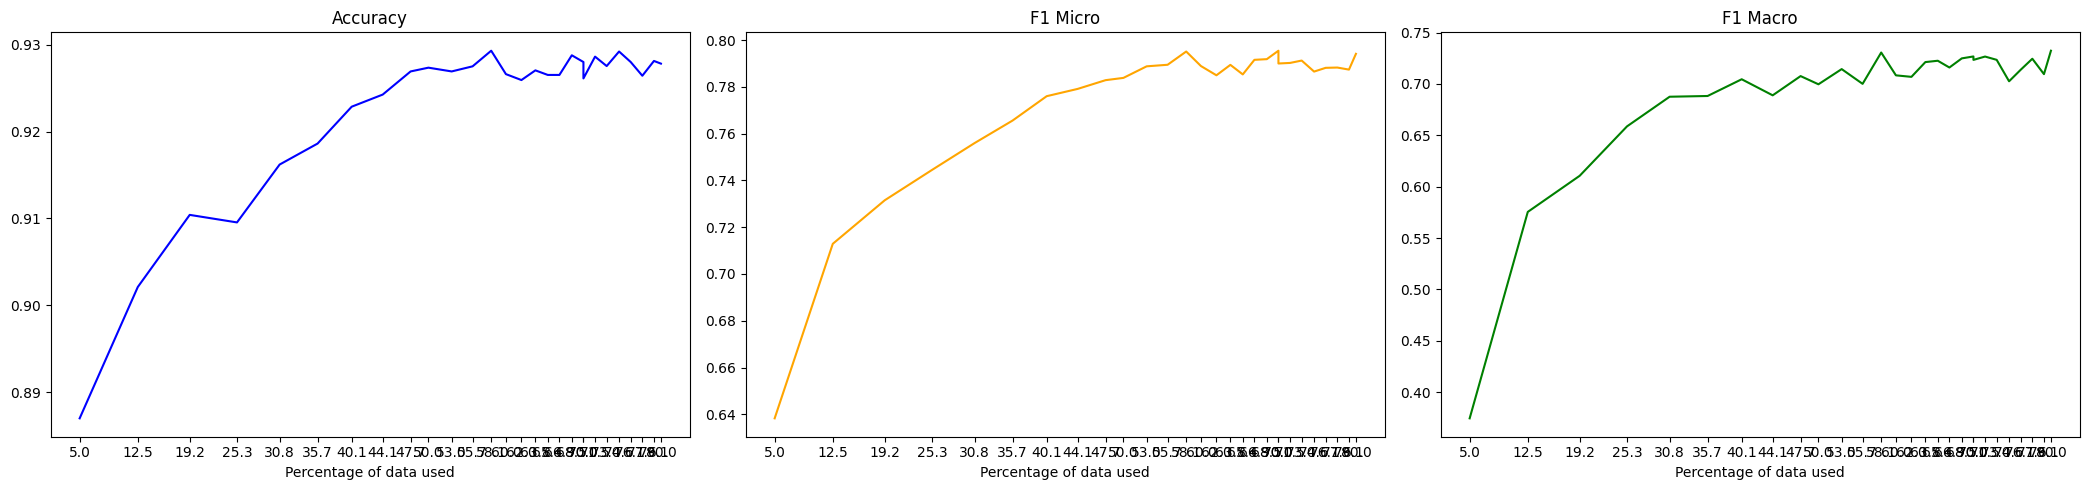

In [27]:
active_learning(seeds[4], 4)